# Νευρωνικά Δίκτυα - Βαθιά Μάθηση
2η Εργασία

Εταγγελίδης Νικόλαος, ΑΕΜ: 10571

Κατηγοριοποίηση δεδομένων του cifar-10 dataset σε οχήματα - ζώα με χρήση SVM

In [1]:
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import random

# In case sklearn was already patched, unpatch it to use the unpatched version of PCA,
# as there is a bug with the patched version
from sklearnex import patch_sklearn, unpatch_sklearn
unpatch_sklearn()
from sklearn.decomposition import PCA

# Then patch all sklearn functions
patch_sklearn()

from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn import preprocessing

from time import time
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Helper Functions

In [2]:
# Plot images of the CIFAR-10 dataset in a grid.
#
#  Args:
#  - num_row: Number of rows for the grid.
# - num_col: Number of columns for the grid.
#- labels: Labels for the images (optional).
#- title: Title for the plot (optional).


def plot_images(images, num_row, num_col, labels, title=None):
    fig, axes = plt.subplots(num_row, num_col, figsize=(2 * num_col, 2 * num_row))
    if title:
        fig.suptitle(title, fontsize=16)

    for i in range(num_row):
        for j in range(num_col):
            index = i * num_col + j
            axes[i, j].imshow(np.reshape(images[index], (32, 32, 3)))
            axes[i, j].axis('off')

            if labels is not None:  # Check if labels is not None
                axes[i, j].set_title(f'Label: {labels[index]}')

    plt.show()





# Example usage:
# Assuming `x_train` is a 2D array where each row is a flattened image,
# and `y_train` is an array of labels.


In [3]:

#Split the CIFAR-10 dataset into two classes, animals and vehicles
# Given an array of labels create an array that holds 0/1 depending on if the 
# label-class is considered an animal/vehicle 
# @args:
# y    -> an array holding indices (labels)
# @output:
# an array that contains 0 if the original label was animal, or 1 if vehicle


#Split the CIFAR-10 dataset into two classes, animals and vehicles
# Given an array of labels create an array that holds 0/1 depending on if the 
# label-class is considered an animal/vehicle 
# @args:
# y    -> an array holding strings (labels)
# @output:
# an array that contains 0 if the original label was animal, or 1 if vehicle

def create_animal_vehicle_array(y):
    animal_classes_indices = [2, 3, 4, 5, 6, 7,] 
    vehicle_classes_indices = [0, 1, 8, 9]  

    animal_vehicle_array = np.zeros(len(y), dtype=int)

    for i, label in enumerate(y):
        if label in animal_classes_indices:
            animal_vehicle_array[i] = 0  # 0 represents an animal
        elif label in vehicle_classes_indices:
            animal_vehicle_array[i] = 1  # 1 represents a vehicle

    return np.array(animal_vehicle_array, dtype=object)



In [4]:
# Given a batch of indices for the dataset, plot these images, and the corresponding
# true and predicted labels
# @args:
# predictions    -> indices of images to plot
# y_test         -> true labels for the set
# y_pred         -> predicted labels for the set
# X_test         -> 2D array holding an image in each row
def show_predictions(predictions, y_test, y_pred, X_test):
    plot_images(X_test[predictions[:10],], 2, 5,\
           y_test[predictions[:10]], "True Labels")

    plot_images(X_test[predictions[:10],], 2, 5,\
            y_pred[predictions[:10]], "Predicted Labels")

In [52]:
# Plot the accuracy VS a parameter of a model, while having a second parameter constant.
# Used to plot accuracy for varying gamma/C while having C/gamma constant and for a specific kernel each time.
# @args:
# df                  -> dataframe containign results of a GridSearchCV
# params_const        -> a list containing the values of the parameter to keep constant in each plot
# param_plot          -> a list containing the values of the parameter to vary in each plot
# vals_const          -> the unique values that the constant parameter can take
# vals_plot           -> the unique values that the varying parameter can take
# name_const          -> name of the parameter to keep constant
# name_plot           -> name of the parameter that varies
# names               -> names to give each subplot
# kernel_name         -> name of the kernel used by the models
def plot_graphs(df, param_const, param_plot, vals_const, vals_plot, name_const, name_plot, names, kernel_name):
    
    # Initialize the figure
    fig = plt.figure(figsize=(15, 12))

    # Iterate through each unique value of the constant paramater
    for i, v in enumerate(vals_const): #enumerate here to get access to i

        # Create a subplot
        ax = plt.subplot(7,2,i+1)

        # Get indices of entries where the const parameter has value v
        focus = (param_const==v)
        
        # Values of the varying parameter when the const is equal to v
        param_varying = param_plot[focus]
        
        # Mean test scores and mean train scores for the models where the const param is equal to v
        mean_test_score = df.mean_test_score[focus]
        mean_train_score = df.mean_train_score[focus]

        # Plot the training and test scores VS the varying parameter, where the constant parameter is equal to v
        ax.plot(param_varying, mean_test_score, '-x', label="test", color="tab:red")
        ax.plot(param_varying, mean_train_score, '-o', label="train",color="tab:blue")
        
        # Since powers of 2 is used for different values of the parameters, set the xscale to log of 2
        ax.set_xscale('log', base=2)
        # Se the ticks to the unique values of the varying parameter
        ax.set_xticks(vals_plot) 
        
        # Set title
        ax.title.set_text(names[i])
        ax.legend(loc="upper left")
    # Set layout
    fig.tight_layout(pad=0.4, w_pad=2.5, h_pad=2.5)
    
    # Set x/y axis labels
    axs = fig.axes
    for ax in axs:
        ax.set(xlabel=name_plot, ylabel='Avg Accuracy')
        
    # Set figure name
    fig.suptitle(f'{kernel_name} Kernel Avg Accuracy Scores for constant {name_const} and varying {name_plot}')
    plt.subplots_adjust(top=0.9)

In [6]:
# Plot the mean fit time VS a parameter of a model, while having a second parameter constant.
# Used to plot accuracy for varying gamma/C while having C/gamma constant and for a specific kernel each time.
# @args:
# df                  -> dataframe containign results of a GridSearchCV
# params_const        -> a list containing the values of the parameter to keep constant in each plot
# param_plot          -> a list containing the values of the parameter to vary in each plot
# vals_const          -> the unique values that the constant parameter can take
# vals_plot           -> the unique values that the varying parameter can take
# name_const          -> name of the parameter to keep constant
# name_plot           -> name of the parameter that varies
# names               -> names to give each subplot
# kernel_name         -> name of the kernel used by the models
def plot_time(df, param_const, param_plot, vals_const, vals_plot, name_const, name_plot, names, kernel_name):
    
    # Initialize the figure
    fig = plt.figure(figsize=(15, 12))

    # Iterate through each unique value of the constant paramater
    for i, v in enumerate(vals_const): #enumerate here to get access to i

        # Create a subplot
        ax = plt.subplot(7,2,i+1)

        # Get indices of entries where the const parameter has value v
        focus = (param_const==v)
        
        # Values of the varying parameter when the const is equal to v
        param_varying = param_plot[focus]
        
        # Get mean fit time when const param = v
        mean_fit_time = df.mean_fit_time[focus]
        
        # Plot mean fit time VS varying parameter
        ax.plot(param_varying, mean_fit_time, '-x', color="tab:purple")

        # Set scale to log of base 2 as values that are equal to a power of 2 are used
        ax.set_xscale('log', base=2)
        
        # Set ticks of both axis
        ax.set_xticks(vals_plot) 
        ax.set_yticks([0, 50, 100, 150])
        ax.title.set_text(names[i])

    # Set layout
    fig.tight_layout(pad=0.4, w_pad=2.5, h_pad=2.5)

    # Set axis' names
    axs = fig.axes
    for ax in axs:
        ax.set(xlabel=name_plot, ylabel='Avg Fit Time (s)')
        
    # Set figure's name
    fig.suptitle(f'{kernel_name} Kernel Avg Fit Time for constant {name_const} and varying {name_plot}')
    plt.subplots_adjust(top=0.9)

# Load Data

In [7]:
# Load the CIFAR-10 dataset from keras' library
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Flatten data 
n = X_train.shape[0]
X_train = np.reshape(X_train, (n, -1))

m = X_test.shape[0]
X_test = np.reshape(X_test, (m, -1))

# Normalize data
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
X_train /= 255.0
X_test /= 255.0

# Set labels of data to animals/vehicle
y_train = create_animal_vehicle_array(y_train)
y_test = create_animal_vehicle_array(y_test)


# PCA
Εκτελούμε PCA, ώστε να κρατηθούν χαρακτηριστικά που να εκφράζουν το 95% της πληροφορίας του dataset

In [8]:
# Fit a PCA model to the training data
pca = PCA(.95)

# (Data is normalized in the previous step, so PCA can be performed)
pca.fit(X_train)

# Transform the data (both train and test) according to the PCA model
x_train_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

In [9]:
print(f"The number of PCA components required to preserve  {pca.explained_variance_ratio_.sum()*100}% of the variance in the data is determined to be: {pca.n_components_}")

The number of PCA components required to preserve  95.02339220373433% of the variance in the data is determined to be: 217


In [10]:
# Since after PCA the data is no longer in the [0,1] range,
# scale them to be in the unit range, in order for the SVM models to run faster
# (Ref: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(x_train_pca)
x_train =  min_max_scaler.transform(x_train_pca)
x_test = min_max_scaler.transform(x_test_pca)

Σε αυτό το σημείο βλέπουμε πως αρκούν μόλις 217 στοιχεία για να διατηρηθεί περίπου το 95% της πληροφορίας. Αυτό, από τα αρχικά 3072. Δηλαδή μόλις 7,06% των χαρακτηριστικών αρκεί για να συγκρατήσουμε το 95% της πληροφορίας

# Show Images
Προβολή μερικών ενδεικτικών εικόνων στην αρχική τους μορφή και σε προσέγγιση της συμπιεσμένης τους μορφής (δηλ. μετά από επιλογή χαρακτηριστικών με χρήση PCA)

## Original Images


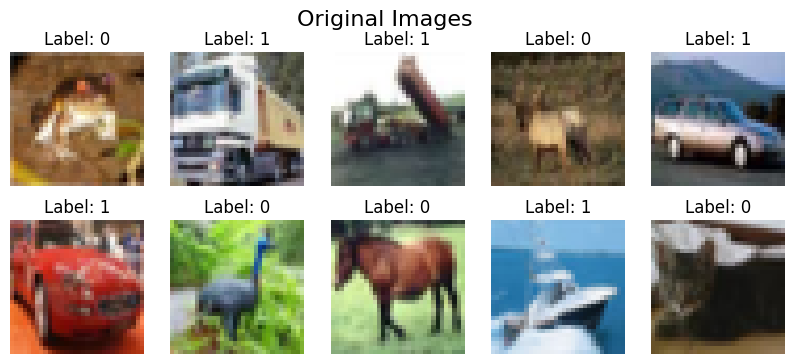

In [11]:
plot_images(X_train[:10,:], 2, 5, y_train[:10], "Original Images")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

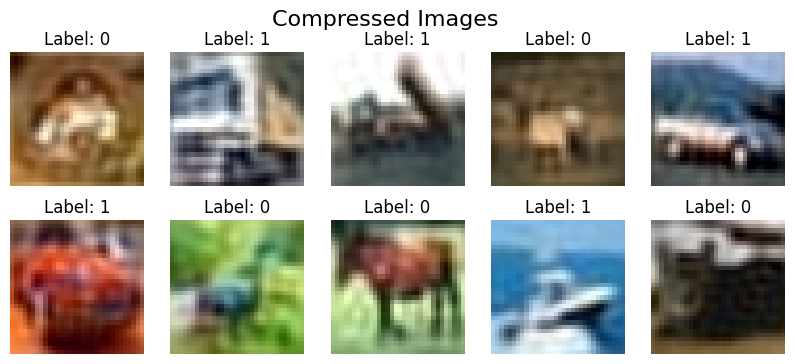

In [12]:
X_train_filt = pca.inverse_transform(x_train_pca)
X_test_filt = pca.inverse_transform(x_test_pca)

plot_images(X_train_filt[:10,:], 2, 5, y_train[:10], "Compressed Images")

# GridSearch


Η επιλογή της βιβλιοθήκης sklearn, συνεπώς και της libsvm που περιέχεται εντός της έγινε με σκοπό την εστίαση στην αλγοριθμική επίλυση και βελτισοτοποίηση του μοντέλου για την λύση του προβλήματος. Καθ' όλη την εργασία και ακόμη περισσότερο, το σημείο αυτό, βάση αποτέλεσε το *Hsu, Chih-wei & Chang, Chih-chung & Lin, Chih-Jen. (2003). A Practical Guide to Support Vector Classification Chih-Wei Hsu, Chih-Chung Chang, and Chih-Jen Lin.* (https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf), και ειδικότερα οι τιμές των παραμέτρων, επιλέχθηκαν με βάση αυτό.

Το Grid Search κάνει δοκιμές με χρήση 5-fold Cross Validation, για κάθε συνδυασμό παραμέτρων, και κατατάσσει τα μοντέλα βάσει της ακρίβειας στο test set.

Τα μοντέλα SVM έχουν τρεις βασικές παραμέτρους που πρέπει να εξεταστούν:

1. Kernel: Αυτή η παράμετρος καθορίζει τον τρόπο με τον οποίο το SVM αντιμετωπίζει τα δεδομένα. Ο γραμμικός πυρήνας είναι απλός και χρησιμοποιείται όταν τα δεδομένα μπορούν να διαχωριστούν γραμμικά. Όταν όμως αυτό δεν είναι δυνατό, χρησιμοποιείται ένα εκ των εναπομείναντων πυρήνων, με σκοπό να υψώσει τα δεδομένα σε μεγαλύτερη διάσταση. Η μετατροπή δεν γίνεται όμως αυτή καθ'αυτή, χρσιμοποιείται όμως το "kernel trick", όπου αντικαθίσταται το εσωτερικό γινόμενο από μία πιο περίπλοκη συνάρτηση πυρήνα.Οπότε υπολογίζεται η "ομοιότητα" σε υψηλότερη διάσταση, χωρίς να χρειαστεί να γίνει ο μετασχηματισμός των δεδομένων. Παρακάτω παρουσιάζονται οι πυρήνες που δοκιμάστηκαν:
    - **Linear**: $K(u, v) = (u' * v)$ Ο πιο απλός πυρήνας. Υπολογίζει απλώς το εσωτερικό γινόμενο μεταξύ των feature vectors των σημείων. Χρησιμοποιείται όταν τα δεδομένα μπορούν να διαχωριστούν γραμμικά. Το decision boundary που παράγεται είναι ένα hyperplane.
    - **Polynomial**: $K(u, v) = (\gamma*u' * v + c_0)^d$, όπου $d$ είναι ο βαθμός του πολυωνύμου και $c_0$ ο ανεξάρτητος όρος. Για να περιοριστεί ο αριθμός των δοκιμών, το $d=3$, $c_0=0$ για κάθε δοκιμή (οι προεπιλεγμένες τιμές της βιβλιοθήκης). Υπολογίζει το εσωτερικό γινόμενο των feature vectors και τα υψώνει σε μία δύναμη, οπότε επιτρέπει πιο περίπλοκο decision boundary. Όμως μεγάλο βαθμός $d$ μπορεί να οδηγήσει σε overfitting.
    - **Sigmoid**: $K(u,v) = tanh(\gamma*u'*v + c_0)$  όπου $c_0$ ο ανεξάρτητος όρος. Για να περιοριστεί ο αριθμός των δοκιμών, $c_0=0$ για κάθε δοκιμή (η προεπιλεγμένη τιμή της βιβλιοθήκης). Μοιάζει με τη logistic function και παράγει decision boundary που μοιάζει με καμπύλη αντί για hyperplane. Συνήθως χρησιμοποιείται σε νευρωνικά δίκτυα, και όχι τόσο συχνά σε SVM, καθώς δεν είναι τόσο αποτελεσματικό όσο οι υπόλοιποι πυρήνες.
    - **RBF (Radial Basis Function)**: $K(u,v) = e^{-\gamma*|u-v|^2}$ Ο πιο σύνηθης πυρήνας που χρησιμοποιείται. Η ομοιότητα είναι σχεδόν ίση με το μηδέν όταν 2 σημεία δεν είναι κοντά. Το decision boundary έχει μορφή καμπύλης.
2. C     : Ελέγχει το trade-off μεταξύ πολυπλοκότητας του μοντέλου και απόκλισης από την τέλεια ταξινόμηση στα δεδομένα εκπαίδευσης. Μεγαλύτερη τιμή δίνει μεγαλύτερο πέναλτι σε λάθη, δημιουργώντας πιο πολύπλοκα μοντέλα, ενώ μικρότερη τιμή το καθιστά πιο απλό και ανεκτικό σε θόρυβο. 
3. $\gamma$ :Αυτή η παράμετρος επηρεάζει τον τρόπο με τον οποίο ο μη-γραμμικός πυρήνας δημιουργεί το decision boundary. Μεγάλη τιμή οδηγεί σε overfitting, ενώ μικρή τιμή δημιουργεί πιο γενικό μοντέλο, χωρίς καλή απόδοση

In [13]:
perform_gridsearch = False # If True, GridSearch will be performed (NOT RECOMMENDED). If False, it will read the results of the already executed GridSearch

In [14]:
# Initialize the C, gamma and kernel values to be tested
C_vals = [2**x for x in [*range(-2,9)]]
gamma_vals = [2**x for x in [*range(-10, 4)]]


param_grid = [
{'C': C_vals, 'kernel': ['linear']},
{'C': C_vals, 'gamma': gamma_vals, 'kernel': ['rbf', 'poly', 'sigmoid']},
]

In [17]:
# Perform the GridSearch or read the results from a CSV file
if perform_gridsearch:
    x_train = x_train.astype('int')
    y_train = y_train.astype('int')
    # Initalize the classifier and the gridsearch
    svc = SVC()
    clf = GridSearchCV(svc, param_grid, return_train_score=True, n_jobs=4)
    
    # Perform the search
    clf.fit(x_train, y_train)
    
    # Load results to a dataframe for easier data manipulation
    df = pd.DataFrame(clf.cv_results_)
    
    # Save the dataframe to a csv file locally
    with open("svm_gridsearch.csv", 'w', encoding = 'utf-8-sig') as f:  
        df.to_csv(f, index=False, lineterminator='\n')
else:
    # Read the gridsearch's results
    df = pd.read_csv("svm_gridsearch.csv")

c:\Users\nicka\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [18]:
# Find the indices of the model(s) with the best rank, meaning rank 1
best_rank = df.rank_test_score==1

# Load info for the best model(s)
best_models = df[best_rank]

# Display it
display(best_models)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
164,51.158506,1.34618,2.274371,0.221647,2,rbf,0.5,"{'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}",0.8987,0.897,...,0.8999,0.002708,1,0.974,0.974425,0.97385,0.973825,0.972525,0.973725,0.000637


In [19]:
# Get only the first best model, in case multiple models have the same rank
best_model = best_models.iloc[0]

# Load the parameters of the best model
best_params = {"C": best_model.param_C, "gamma": best_model.param_gamma, "kernel": best_model.param_kernel}

In [20]:
print(f"Best parameters found by GridSearch: {best_params}")

Best parameters found by GridSearch: {'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}


# Πίνακες Αποτελεσμάτων

Παρακάτω παρουσιάζονται οι πληροφορίες του κάθε μοντέλου σε πίνακες, καθώς και το μέσο χρόνο εκπαίδευσης, μέση ακρίβεια στα σύνολα εκπαίδευσης και test.

In [21]:
pd.set_option('display.max_rows', None)

## Linear Kernel Πίνακας Αποτελεσμάτων

In [24]:
df_linear =  df.loc[df['param_kernel'] == 'linear', ["mean_fit_time", "param_C", "mean_test_score", "mean_train_score"]]

In [25]:
df_linear

,mean_fit_time,param_C,mean_test_score,mean_train_score
0,17.006361,0.25,0.82070,0.824175
1,18.263553,0.5,0.82068,0.824690
2,20.821060,1,0.82084,0.824720
3,23.785822,2,0.82100,0.824865
4,26.150601,4,0.82100,0.825055
5,28.639542,8,0.82104,0.825085
6,32.854265,16,0.82100,0.825095
7,38.272447,32,0.82114,0.825160
8,46.023906,64,0.82104,0.825160
9,65.684610,128,0.82102,0.825175


## RBF Kernel Πίνακας Αποτελεσμάτων

In [26]:
df_rbf =  df.loc[df['param_kernel'] == 'rbf', ["mean_fit_time", "param_C", "param_gamma", "mean_test_score", "mean_train_score"]]

In [27]:
df_rbf

,mean_fit_time,param_C,param_gamma,mean_test_score,mean_train_score
11,12.541247,0.25,0.000977,0.60000,0.600000
14,20.321057,0.25,0.001953,0.60000,0.600000
17,21.851955,0.25,0.003906,0.61788,0.618405
20,20.132508,0.25,0.007812,0.76906,0.771015
23,20.939842,0.25,0.015625,0.79974,0.801630
26,18.505785,0.25,0.03125,0.81204,0.814130
29,18.255670,0.25,0.0625,0.82306,0.826670
32,14.840880,0.25,0.125,0.83796,0.844985
35,17.657078,0.25,0.25,0.85878,0.873610
38,17.764975,0.25,0.5,0.87466,0.903400


## Poly Kernel Πίνακας Αποτελεσμάτων

In [28]:
df_poly =  df.loc[df['param_kernel'] == 'poly', ["mean_fit_time", "param_C", "param_gamma", "mean_test_score", "mean_train_score"]]

In [29]:
df_poly

,mean_fit_time,param_C,param_gamma,mean_test_score,mean_train_score
12,17.927385,0.25,0.000977,0.60000,0.600000
15,21.531935,0.25,0.001953,0.60000,0.600000
18,23.690554,0.25,0.003906,0.60000,0.600000
21,24.040754,0.25,0.007812,0.60000,0.600000
24,22.952103,0.25,0.015625,0.79256,0.794550
27,18.981545,0.25,0.03125,0.82208,0.825480
30,22.845619,0.25,0.0625,0.84210,0.850745
33,35.384088,0.25,0.125,0.88328,0.911440
36,171.705095,0.25,0.25,0.89026,0.965000
39,549.751897,0.25,0.5,0.86472,0.993855


## Sigmoid Kernel Πίνακας Αποτελεσμάτων

In [30]:
df_sigmoid =  df.loc[df['param_kernel'] == 'sigmoid', ["mean_fit_time", "param_C", "param_gamma", "mean_test_score", "mean_train_score"]]

In [31]:
df_sigmoid

,mean_fit_time,param_C,param_gamma,mean_test_score,mean_train_score
13,23.605206,0.25,0.000977,0.60000,0.600000
16,22.115822,0.25,0.001953,0.60000,0.600000
19,23.987742,0.25,0.003906,0.60000,0.600000
22,23.821421,0.25,0.007812,0.60478,0.604915
25,23.335773,0.25,0.015625,0.66514,0.665365
28,25.318673,0.25,0.03125,0.60100,0.601050
31,22.405446,0.25,0.0625,0.60000,0.600000
34,22.744729,0.25,0.125,0.60000,0.600000
37,5.203161,0.25,0.25,0.50870,0.508685
40,4.890000,0.25,0.5,0.40000,0.400000


# Γραφήματα Αποτελεσμάτων
Παρακάτω παρουσιάζονται γραφήματα της ακρίβειας των μοντέλων τόσο στα δεδομένα εκπαίδευσης όσο και στα δεδομένα test.

Για τα μη-γραμμικά μοντέλα όπου έχουν 2 υπερπαραμέτρους (εκτός του πυρήνα) γ και C, παρουσιάζονται γραφήματα όταν μία από τις 2 παραμέτρους είναι σταθερή, καθώς και σχόλια.

## Γραφήματα Accuracy

#### Σταθερό gamma και διάφορες τιμές C

### Rbf Kernel

In [32]:
g_names = list(map(lambda x: "g = $2^{{{}}}$".format(x), range(-10,4)))
C_names = list(map(lambda x: "C = $2^{{{}}}$".format(x), range(-2,9)))

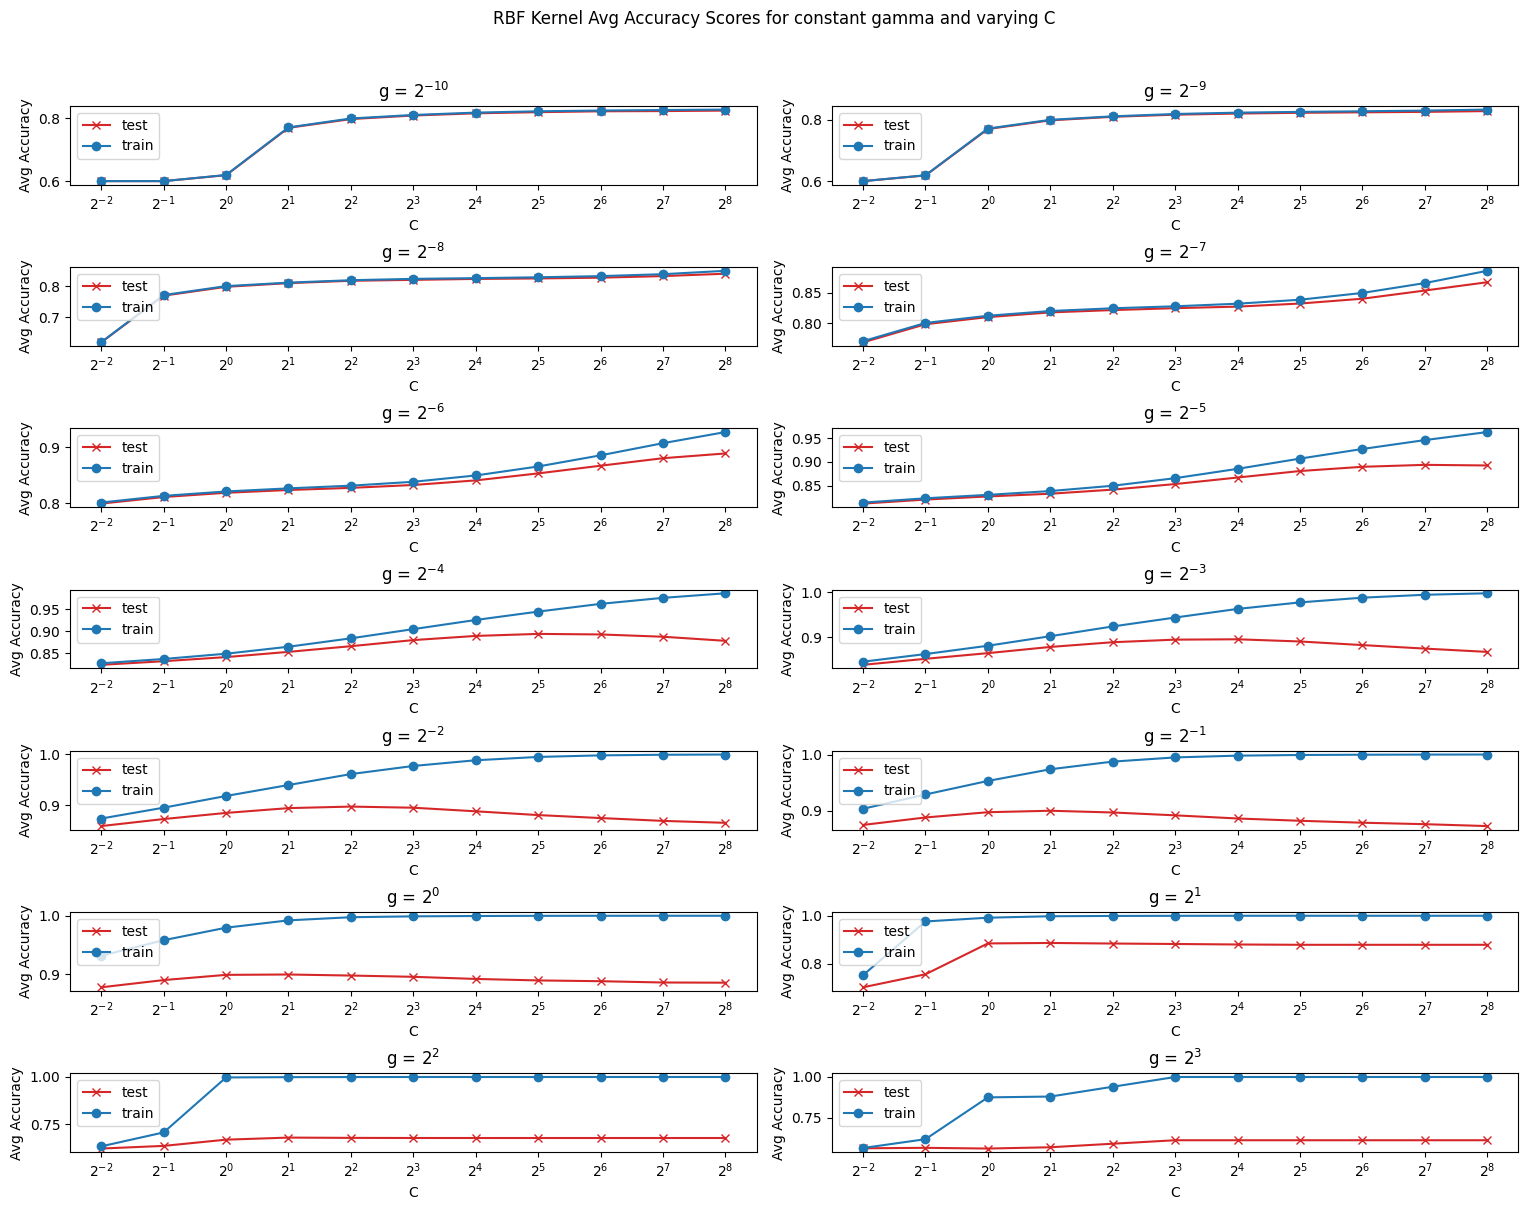

In [33]:
plot_graphs(df_rbf, df_rbf.param_gamma, df_rbf.param_C, gamma_vals, C_vals, "gamma", "C", g_names, "RBF")

Παρατηρούμε ότι περίπου μέχρι $\gamma=2^{-5}$, η αύξηση του C προκαλεί βελτίωση στην απόδοση του μοντέλου, ενώ για τις επόμενες τιμές του $\gamma$, από $C=2$ περίπου, η ακρίβεια παραμένει στα ίδια επίπεδα, ή και μειώνεται. Ειδικότερα για $\gamma>=2$, η αύξηση του C μετά από $C>1$ πρακτικά δεν επηρεάζει.
Τέλος παρατηρούμε ότι για μεγάλες τιμές γ ($2^2 - 2^3$), παρουσιάζεται overfitting, που είναι λογικό, καθώς όσο μεγαλύτερο το γ, τόσο επηρεάζει κάθε σημείο των δεδομένων εκπαίδευσης, άρα εν τέλει το μοντέλο προσαρμόζεται υπερβολικά στα δεδομένα εκπαίδευσης.

#### Σταθερό C και διάφορες τιμές gamma

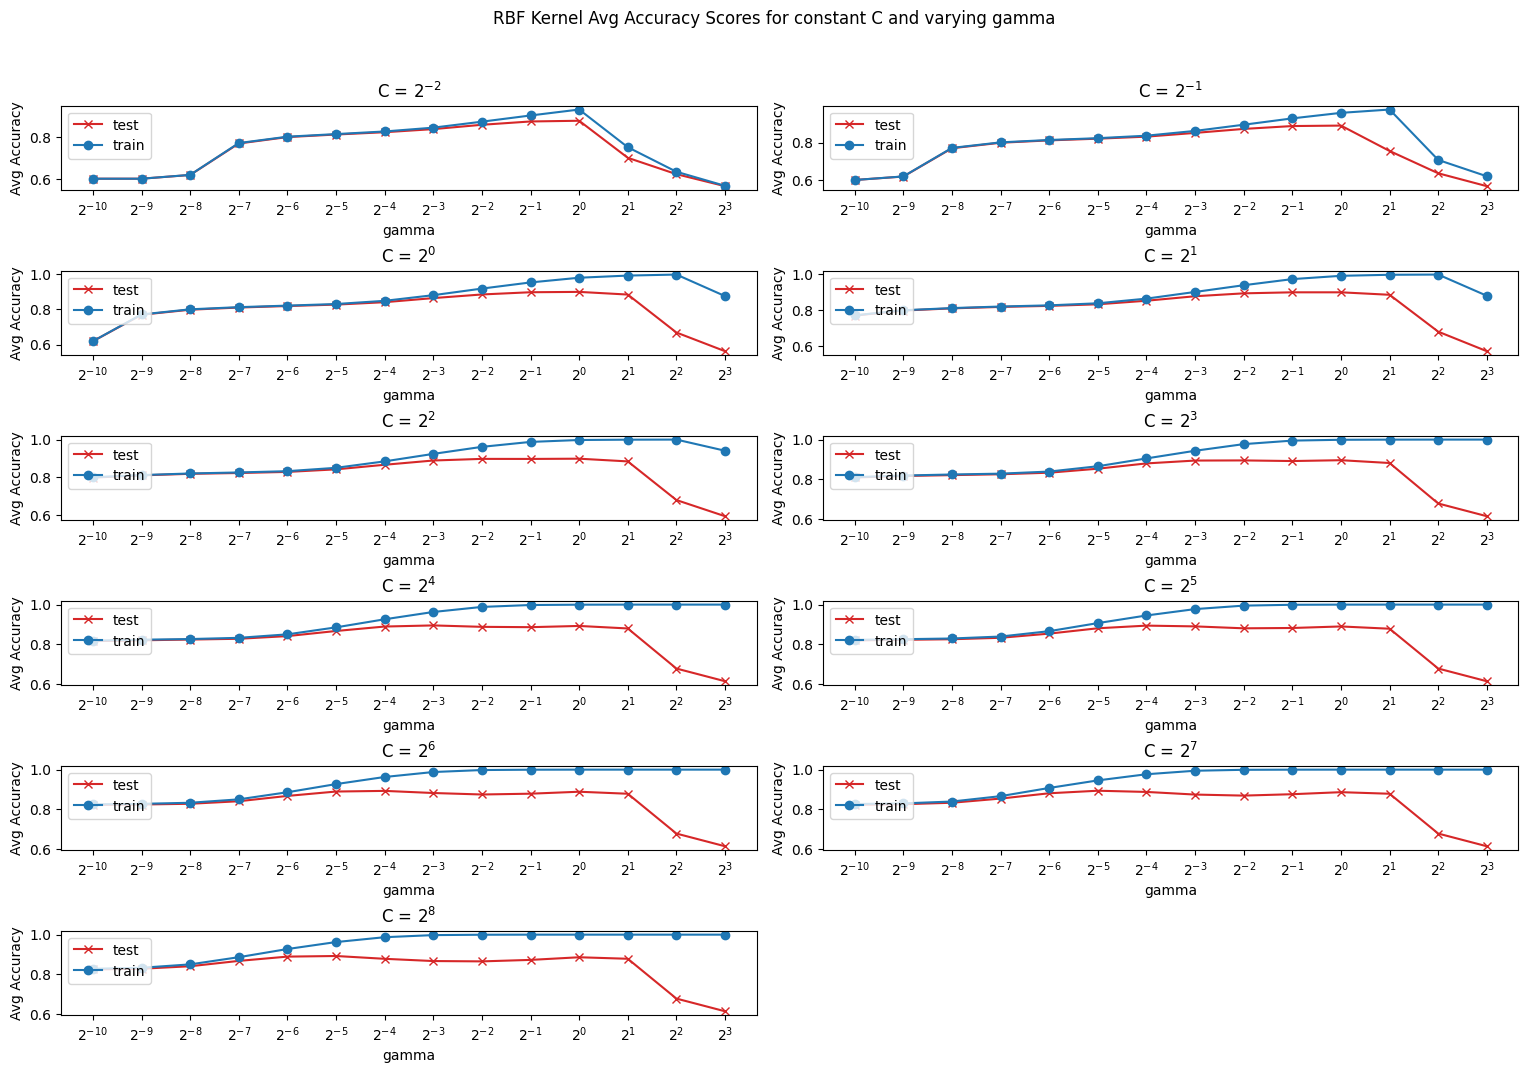

In [34]:
plot_graphs(df_rbf, df_rbf.param_C, df_rbf.param_gamma, C_vals, gamma_vals, "C", "gamma", C_names, "RBF")

Κρατώντας σταθερή πλέον την παράμετρο C, βλέπουμε πάλι πως για μεγάλα γ παρατηρείται κακή απόδοση στο test dataset και καλή στο train (overfitting), ενώ αυτό είναι πιο έντονο ειδικά όταν $C>1$, όπου εφόσον δίνεται μεγαλύτερο penalty στα δεδομένα του συνόλου εκπαίδευσης, το μοντέλο προσαρμόζεται περισσότερο σε αυτό (το σύνολο εκπαίδευσης), οπότε το φαινόμενο είναι πιο έντονο όταν και το γ είναι υψηλό. Γενικότερα παρατηρούμε ότι για τιμές $ 2^{-6} <= \gamma <= 2^ {-4} $ για όλα τα C η ακρίβεια είναι υψηλή, και κοντινή μεταξύ των δεδομένων training & testing.

### Sigmoid Kernel

#### Σταθερό gamma και διάφορες τιμές C

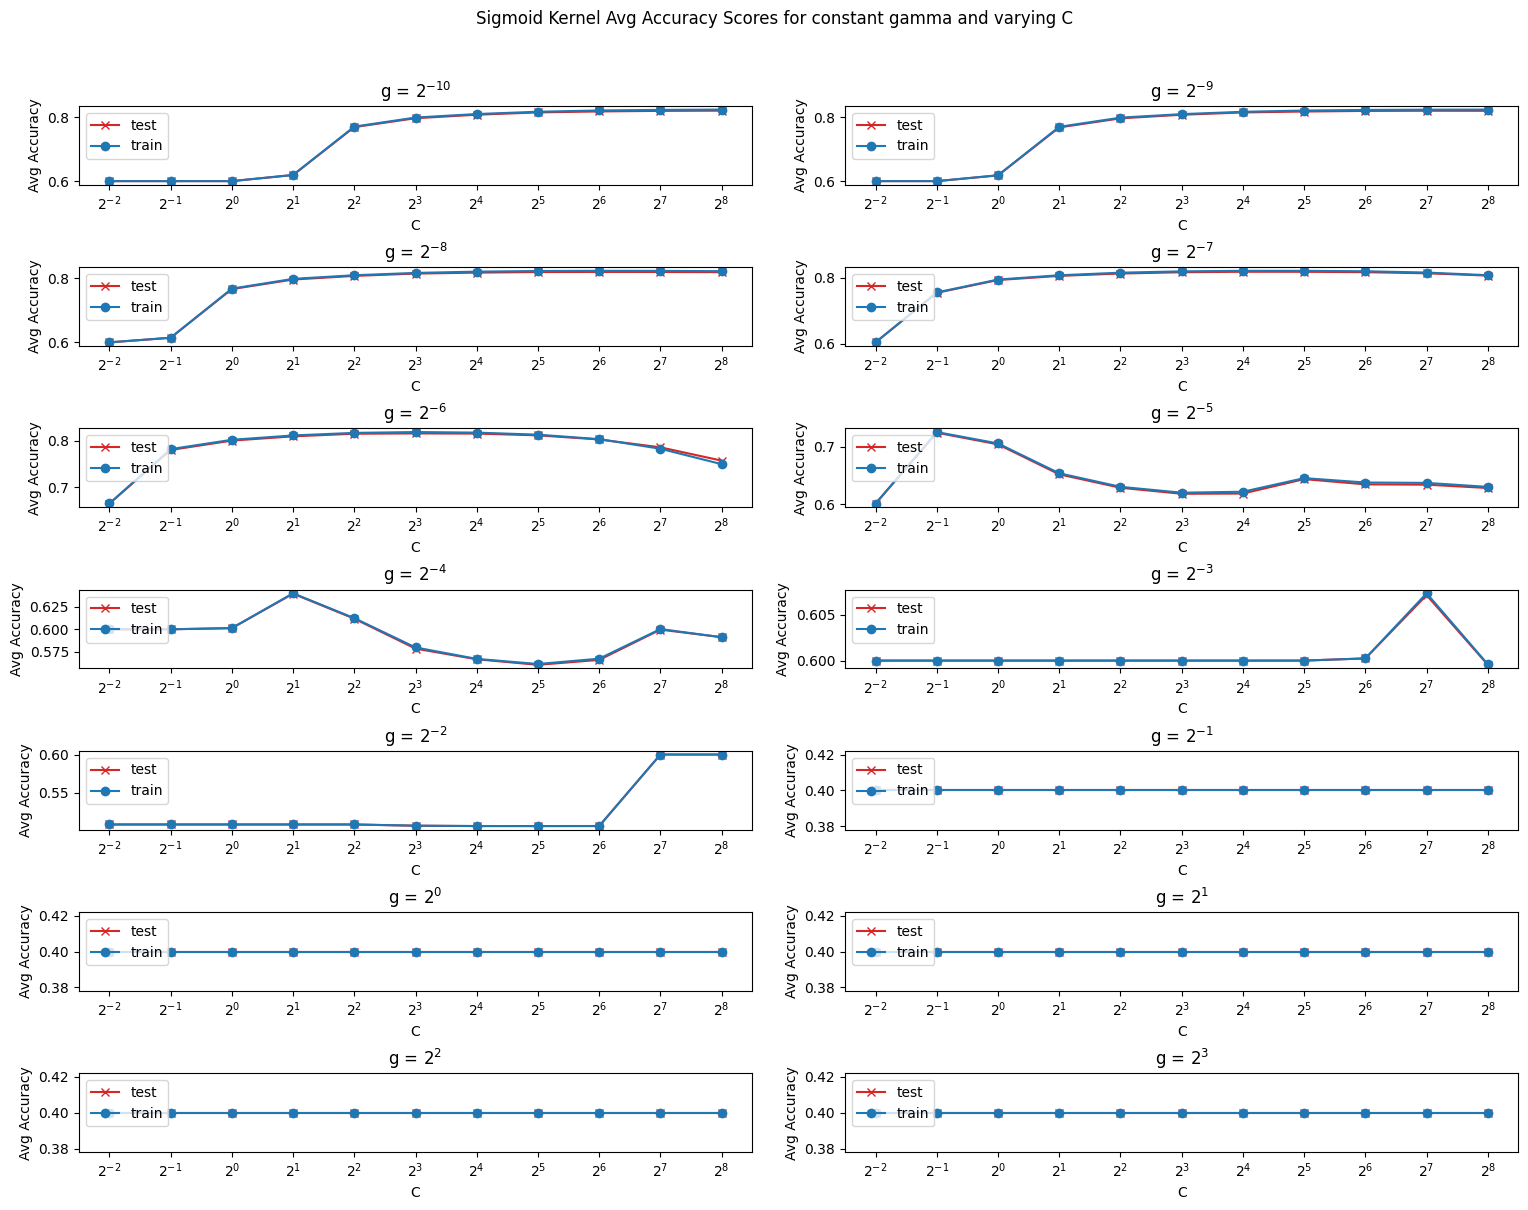

In [35]:
plot_graphs(df_sigmoid, df_sigmoid.param_gamma, df_sigmoid.param_C, gamma_vals, C_vals, "gamma", "C", g_names, "Sigmoid")

Παρατηρούμε ότι μόνο για μικρά γ ($2^{-10} - 2^{-6}$) υπάρχει σχετικά υψήλη απόδοση των μοντέλων που χρησιμοποιούν Sigmoid Kernel.

#### Σταθερό C και διάφορες τιμές gamma

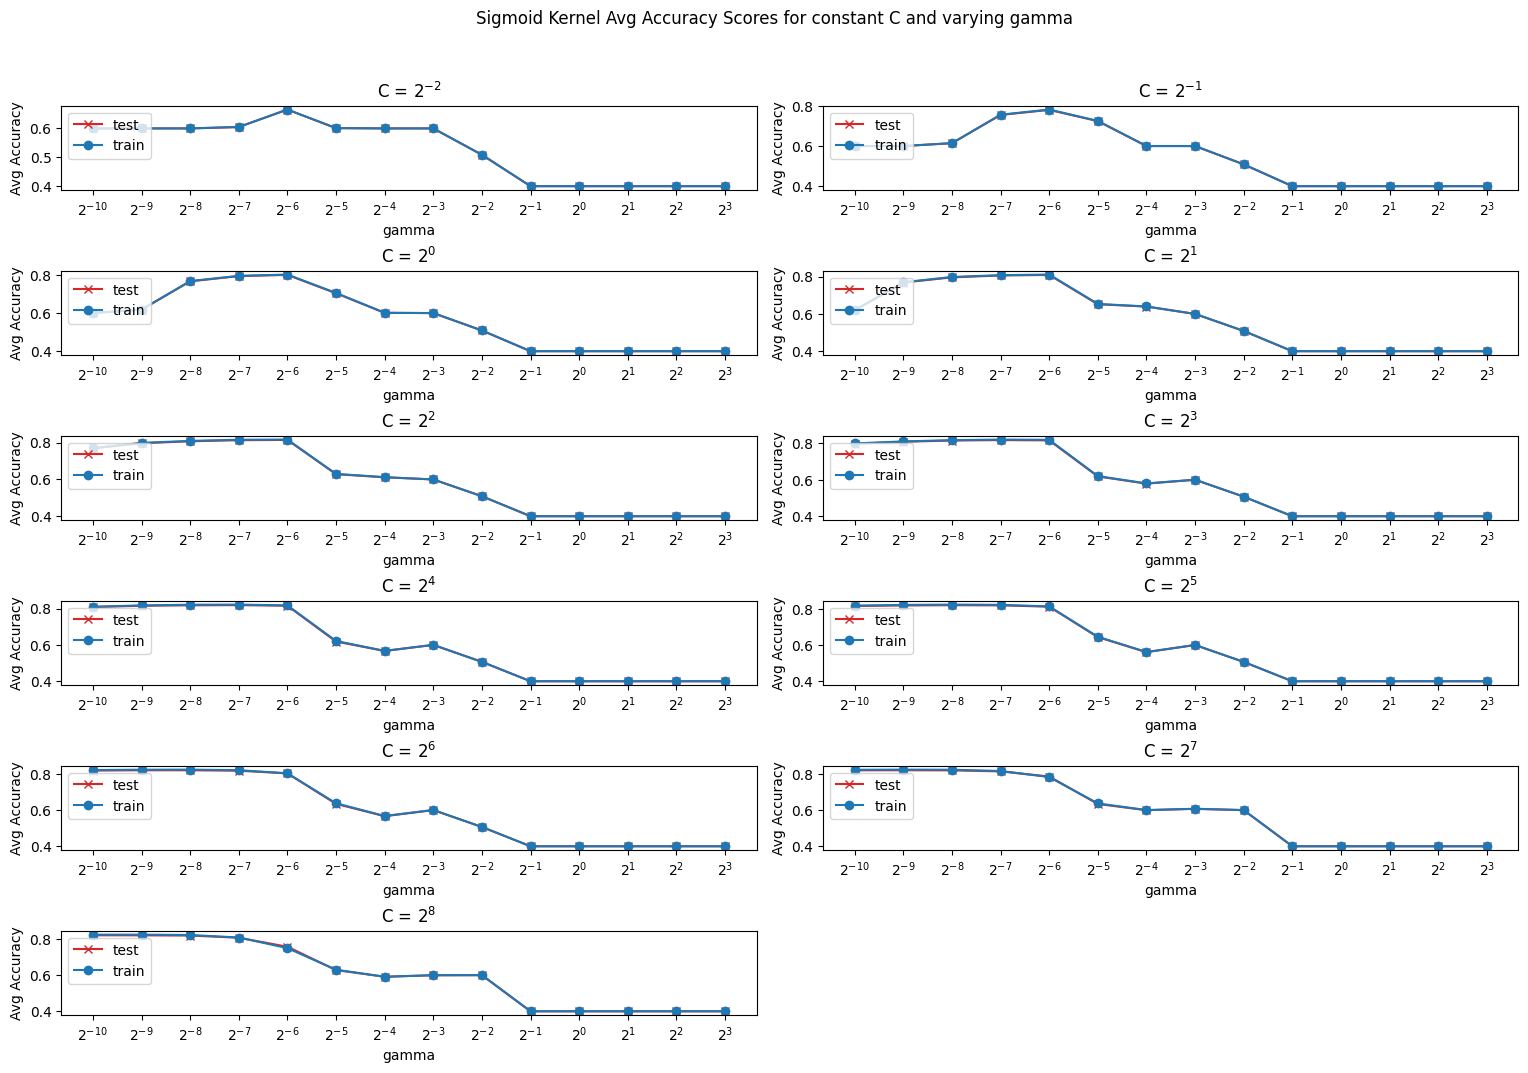

In [36]:
plot_graphs(df_sigmoid, df_sigmoid.param_C, df_sigmoid.param_gamma, C_vals, gamma_vals, "C", "gamma", C_names, "Sigmoid")

Εδώ γίνεται πιο φανερό ότι όσο αυξάνει το γ, τόσο πέφτει η απόδοση, ενώ ειδικά για μικρά C,  για να υπάρχει σχετικά υψήλη απόδοση πρέπει το γ να είναι σε μία μέση περιοχή των τιμών που δοκιμάστηκαν.

### Poly Kernel

#### Σταθερό gamma και διάφορες τιμές C


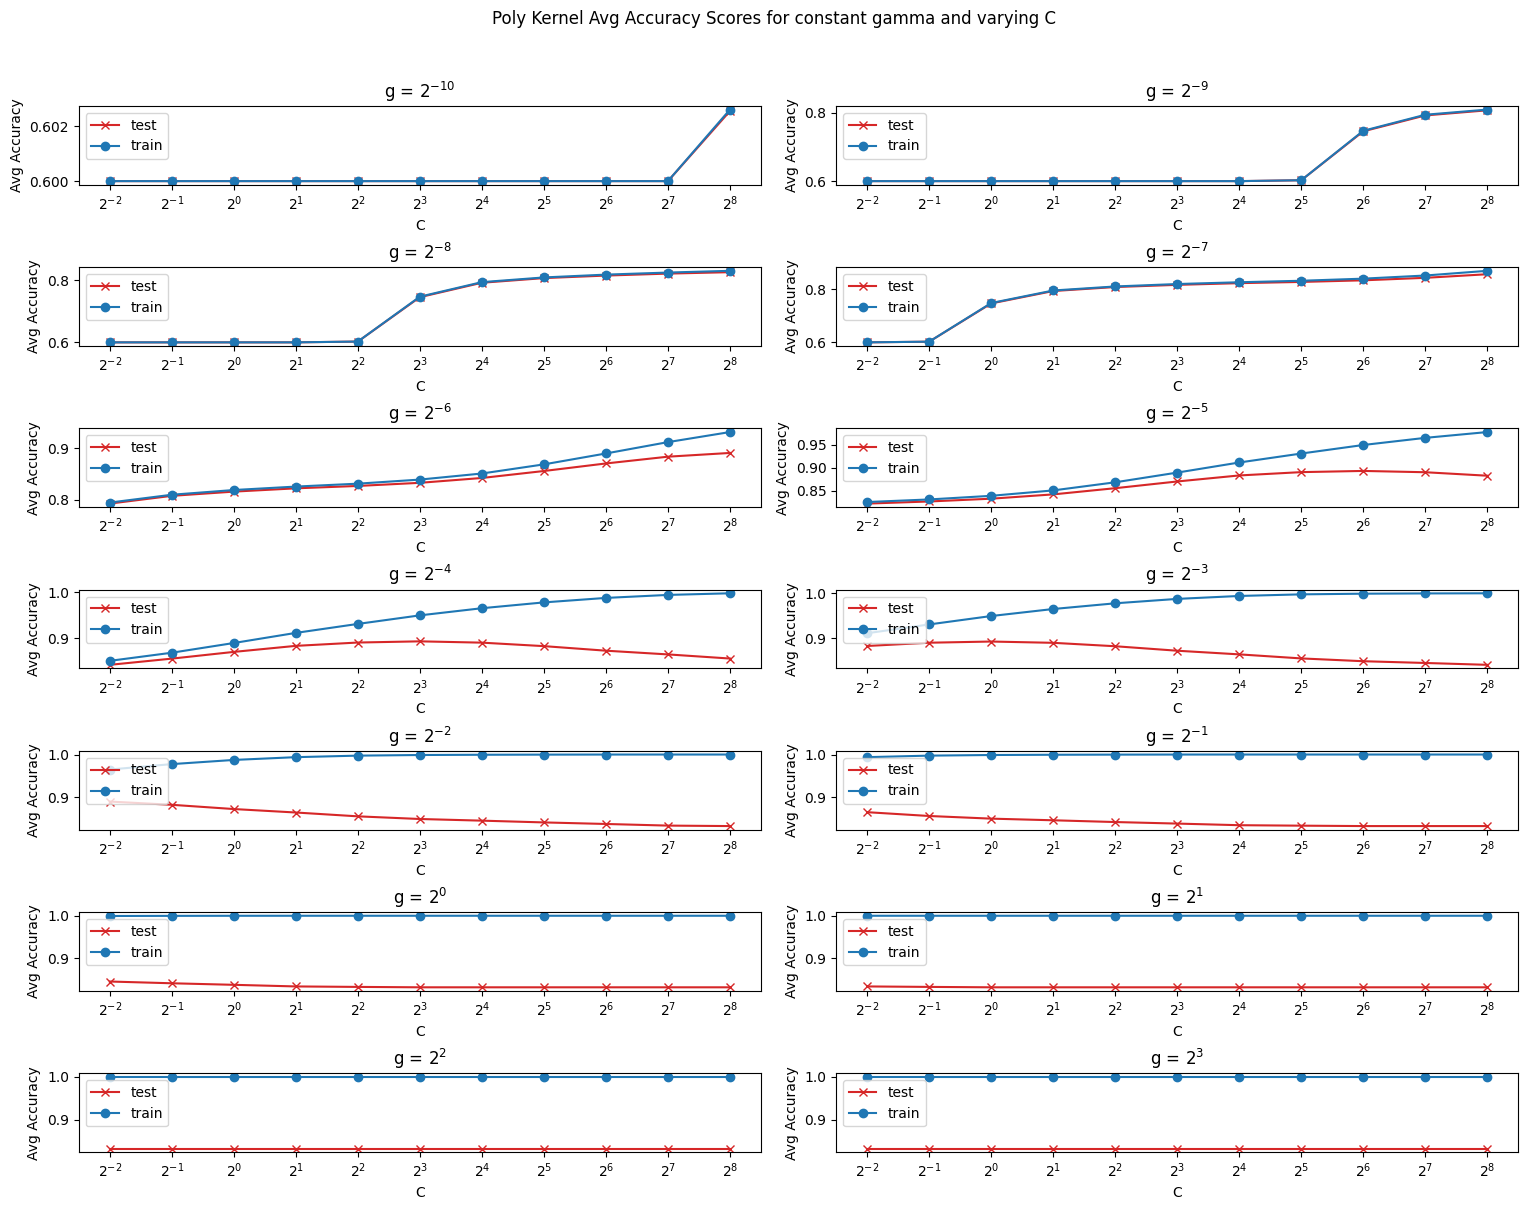

In [37]:
plot_graphs(df_poly, df_poly.param_gamma, df_poly.param_C, gamma_vals, C_vals, "gamma", "C", g_names, "Poly")

Παρατηρούμε ότι για γ έως $2^{-6}$, η αύξηση του C βοηθάει να αυξηθεί η ακρίβεια του μοντέλου. Όμως όταν γ παίρνει τιμές μεγαλύτερες από $2^{-6}$, εώς $2 ^{-1}$ , το αυξανόμενο C μειώνει την ακρίβεια του μοντέλου ενώ για γ μεγαλύτερο του $2^{-6}$, το C πρακτικά δεν επηρεάζει την ακρίβεια των μοντέλων η οποία μένει σχεδόν αμετάβλητη με αλλαγές στο C.

Η απόδοση των μοντέλων για τα δεδομένα training & testing είναι κοντινή και σε υψηλές τιμές. Βλέπουμε όμως ότι για τις τιμές του γ που αναφέρθηκαν πριν, η ακρίβεια είναι 100% στα δεδομένα εκπαίδευσης, και αρκετά μικρότερη στο test set,αυτό σημαίνει ότι υπάρχει overfitting.

#### Σταθερό C και διάφορες τιμές gamma

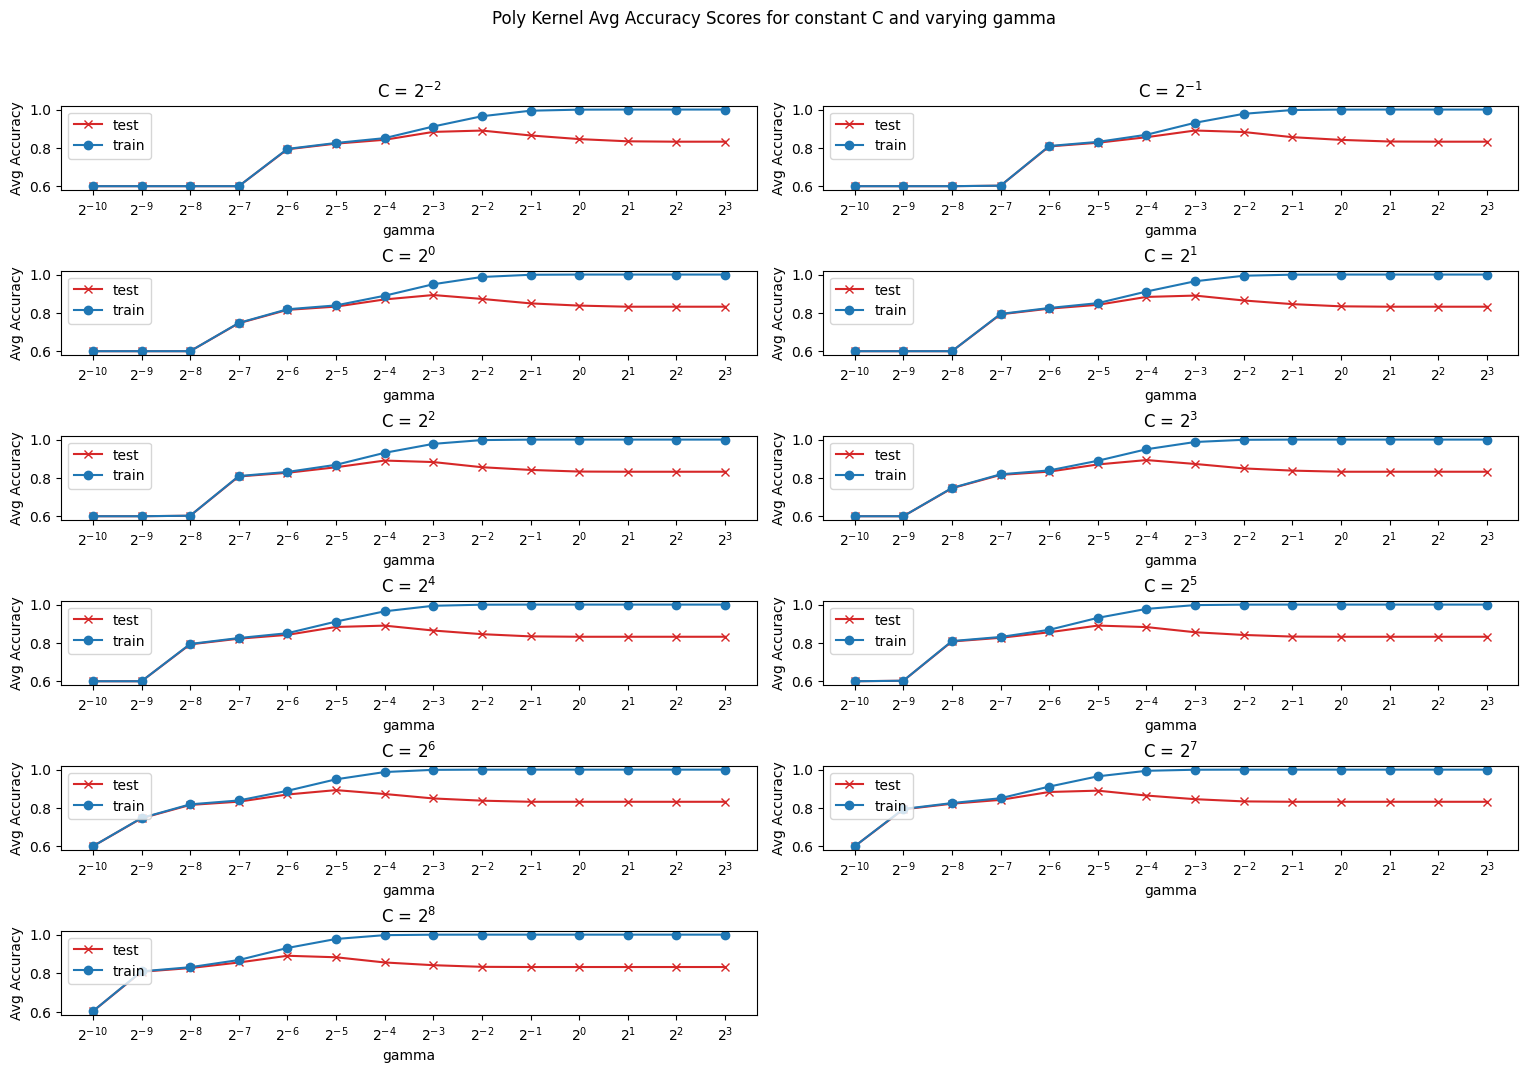

In [40]:
plot_graphs(df_poly, df_poly.param_C, df_poly.param_gamma, C_vals, gamma_vals, "C", "gamma", C_names, "Poly")

Συνεχίζοντας τις παραπάνω παρατηρήσεις, πάλι βλέπουμε ότι οι τιμές γ μεγαλύτερες του $2^{-4}$ επιφέρουν καλύτερη απόδοση για κάθε C.

### Linear Kernel

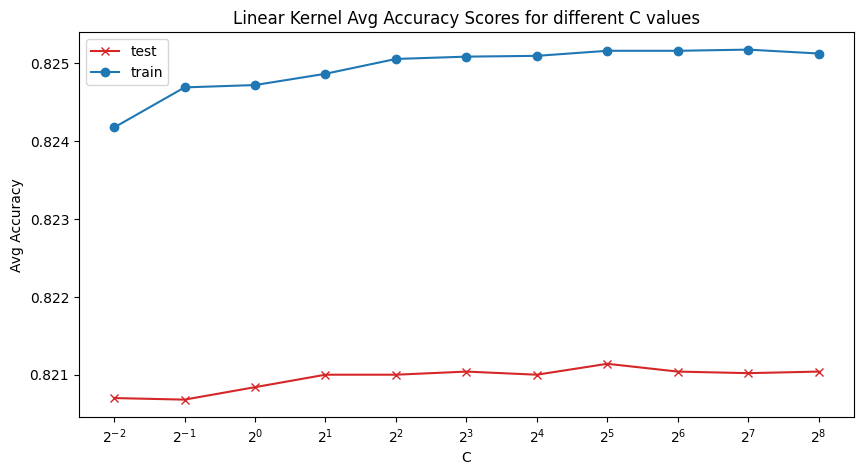

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

param_C = df_linear.param_C
mean_test_score = df_linear.mean_test_score
mean_train_score = df_linear.mean_train_score

ax.plot(param_C, mean_test_score, '-x', label="test", color="tab:red")
ax.plot(param_C, mean_train_score, '-o', label="train",color="tab:blue")
ax.set_xscale('log', base=2)
ax.set_xticks(C_vals) 
ax.title.set_text("Linear Kernel Avg Accuracy Scores for different C values")
ax.set(xlabel="C", ylabel='Avg Accuracy')
ax.legend(loc="upper left")

plt.show()

Παρατηρούμε ότι η μεταβλητή C δεν επηρεάζει σχεδόν καθόλου την ακρίβεια του μοντέλου, η οποία συγκριτικά με τα καλά μοντέλα των μη-γραμμικών kernels, είναι χαμηλή.

Παρόλα αυτά, αντιθέτως, η ακρίβεια των μοντέλων που κάνουν χρήση γραμμικού kernel, είναι κατά πολύ υψηλότερη από τα μοντέλα χαμηλής απόδοσης με μη-γραμμικό kernel, και μάλιστα παρατηρούμε ότι η απόδοση είναι σχεδόν ίδια στα δεδομενα training & test (~82%).

Ακόμη, για να γίνει χρήση ενός SVM με γραμμικό πυρήνα αρκεί να γίνουν δοκιμές μόνο για μια υπερπαράμετρο, που μάλιστα στην συγκεκριμένη εφαρμογή, δεν επηρεάζει αισθητά την ακρίβεια. Οπότε, είναι πολύ πιο γρήγορο να γίνει η επιλογή παραμέτρων για SVM με γραμμικό kernel.


### Συνολικές Παρατηρήσεις

Μεταξύ των τεσσάρων kernels, βλέπουμε ότι το sigmoid kernel αποδίδει χειρότερα, ενώ τα άλλα 2 μη-γραμμικά kernels (RBF & Polynomial) αποδίδουν πάρα πολύ καλά **με σωστή επιλογή των παραμέτρων γ, C**.

Όσο αφορά το γραμμικό kernel, βλέπουμε ότι μπορεί να έχει χαμηλότερη απόδοση από τα μοντέλα με μη-γραμμικό kernel και σωστή επιλογή παραμέτρων, όμως "out of the box" λειτουργεί σε σχετικά υψηλή ακρίβεια, χωρίς να χρειαστεί να γίνει ιδιαίτερη διερεύνηση για την επιλογή των παραμέτρων του.

## Γραφήματα Χρόνου Εκπαίδευσης

### RBF Kernel

#### Σταθερό gamma και διάφορες τιμές C

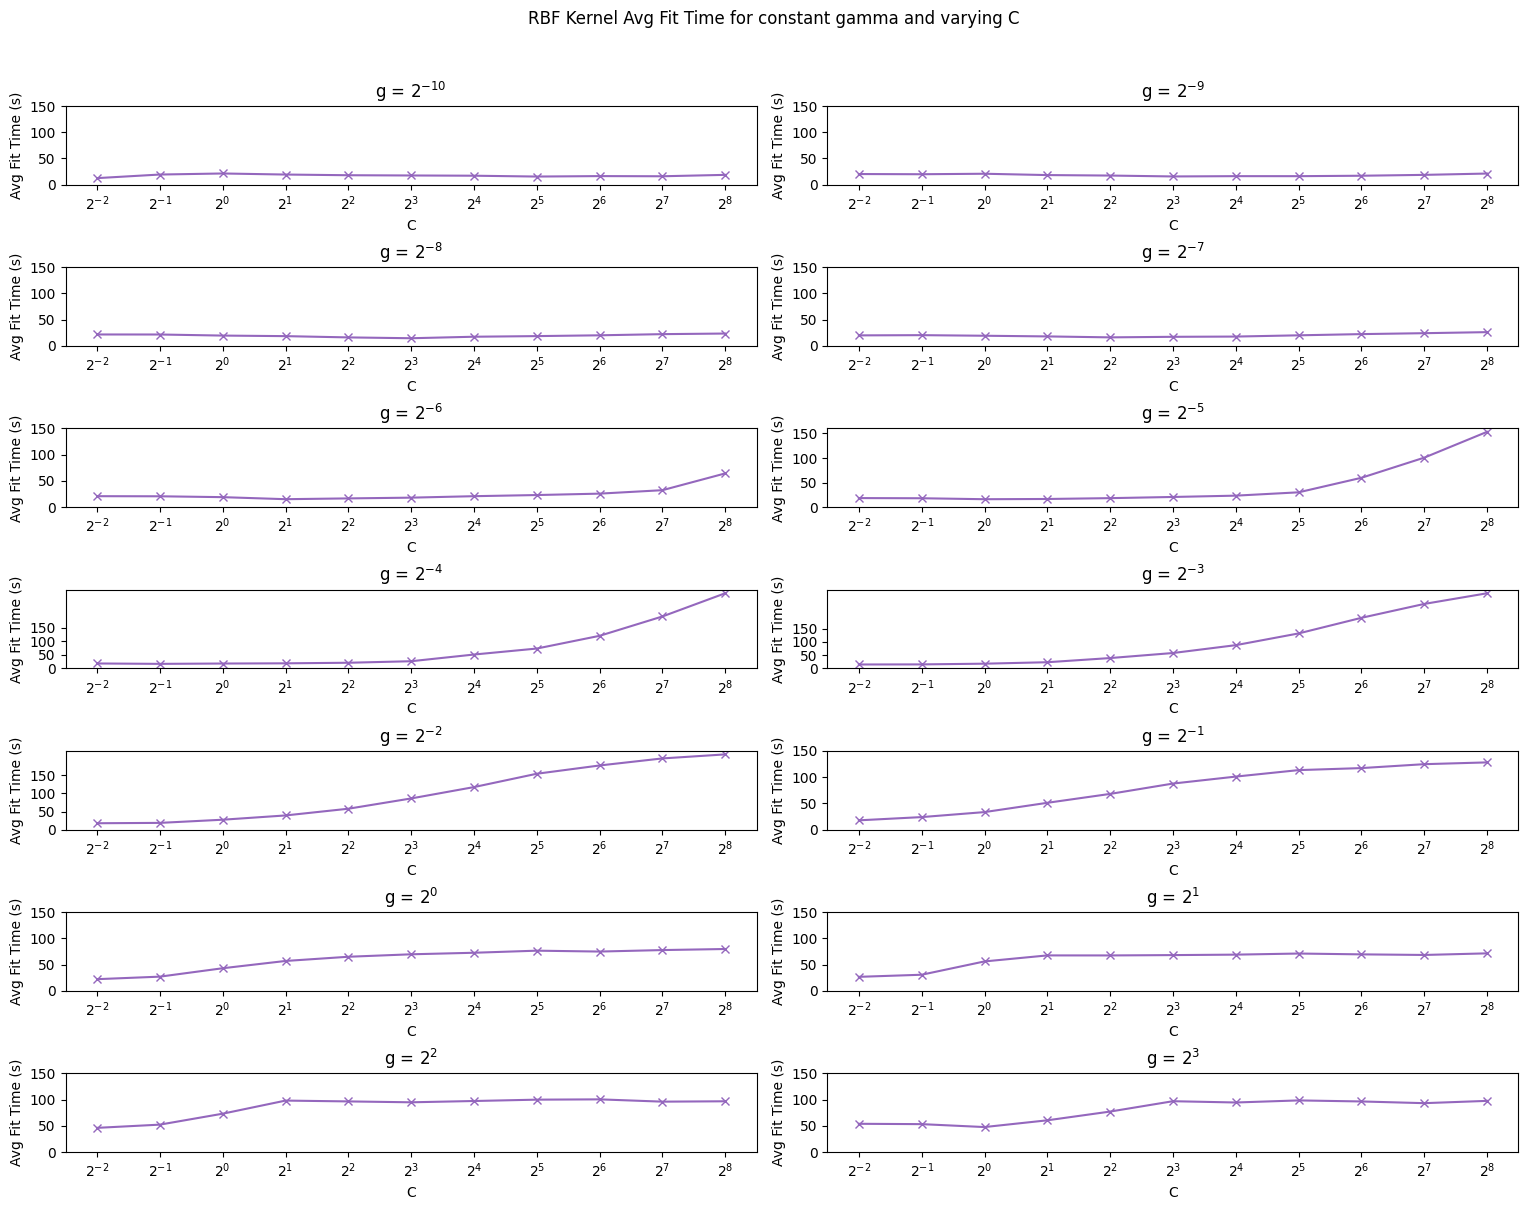

In [42]:
plot_time(df_rbf, df_rbf.param_gamma, df_rbf.param_C, gamma_vals, C_vals, "gamma", "C", g_names, "RBF")

#### Σταθερό C και διάφορες τιμές gamma

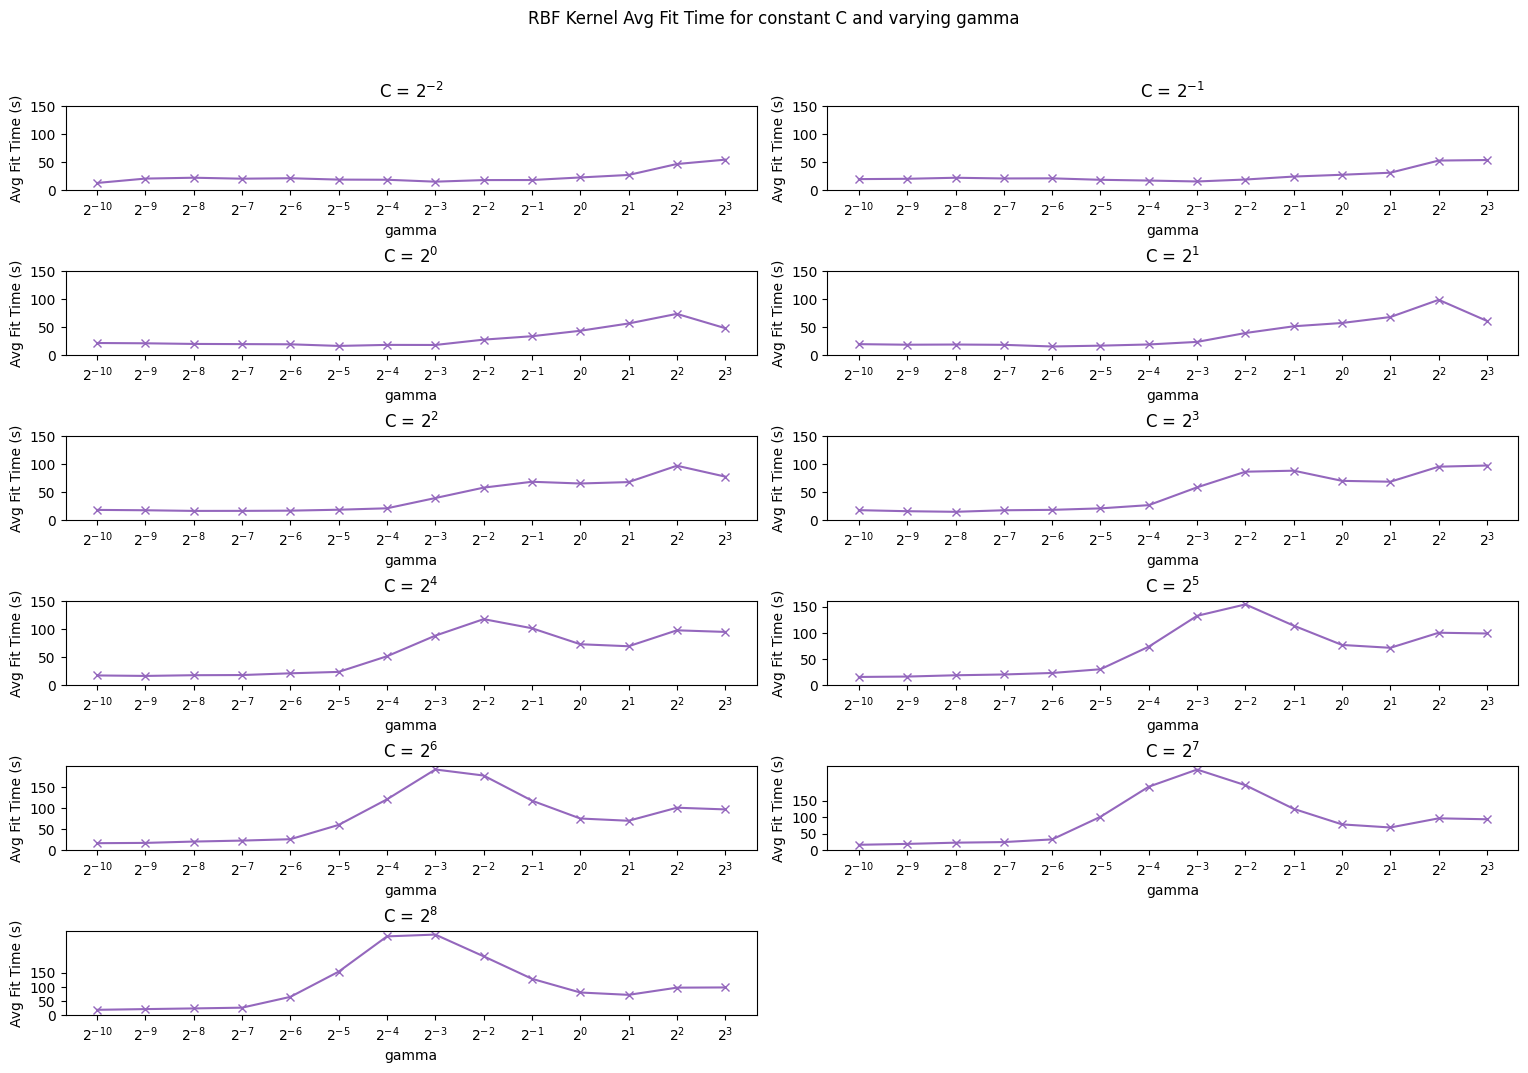

In [43]:
plot_time(df_rbf, df_rbf.param_C, df_rbf.param_gamma, C_vals, gamma_vals, "C", "gamma", C_names, "RBF")

Παρατηρούμε ότι για σχετικά μικρά γ η επιλογή του C δεν επηρεάζει το fit time, ενώ για μεγαλύτερα αυξάνει ο χρόνος, και αυξάνει ακόμη παραπάνω όταν αυξάνει και το C.

### Sigmoid Kernel

#### Σταθερό gamma και διάφορες τιμές C

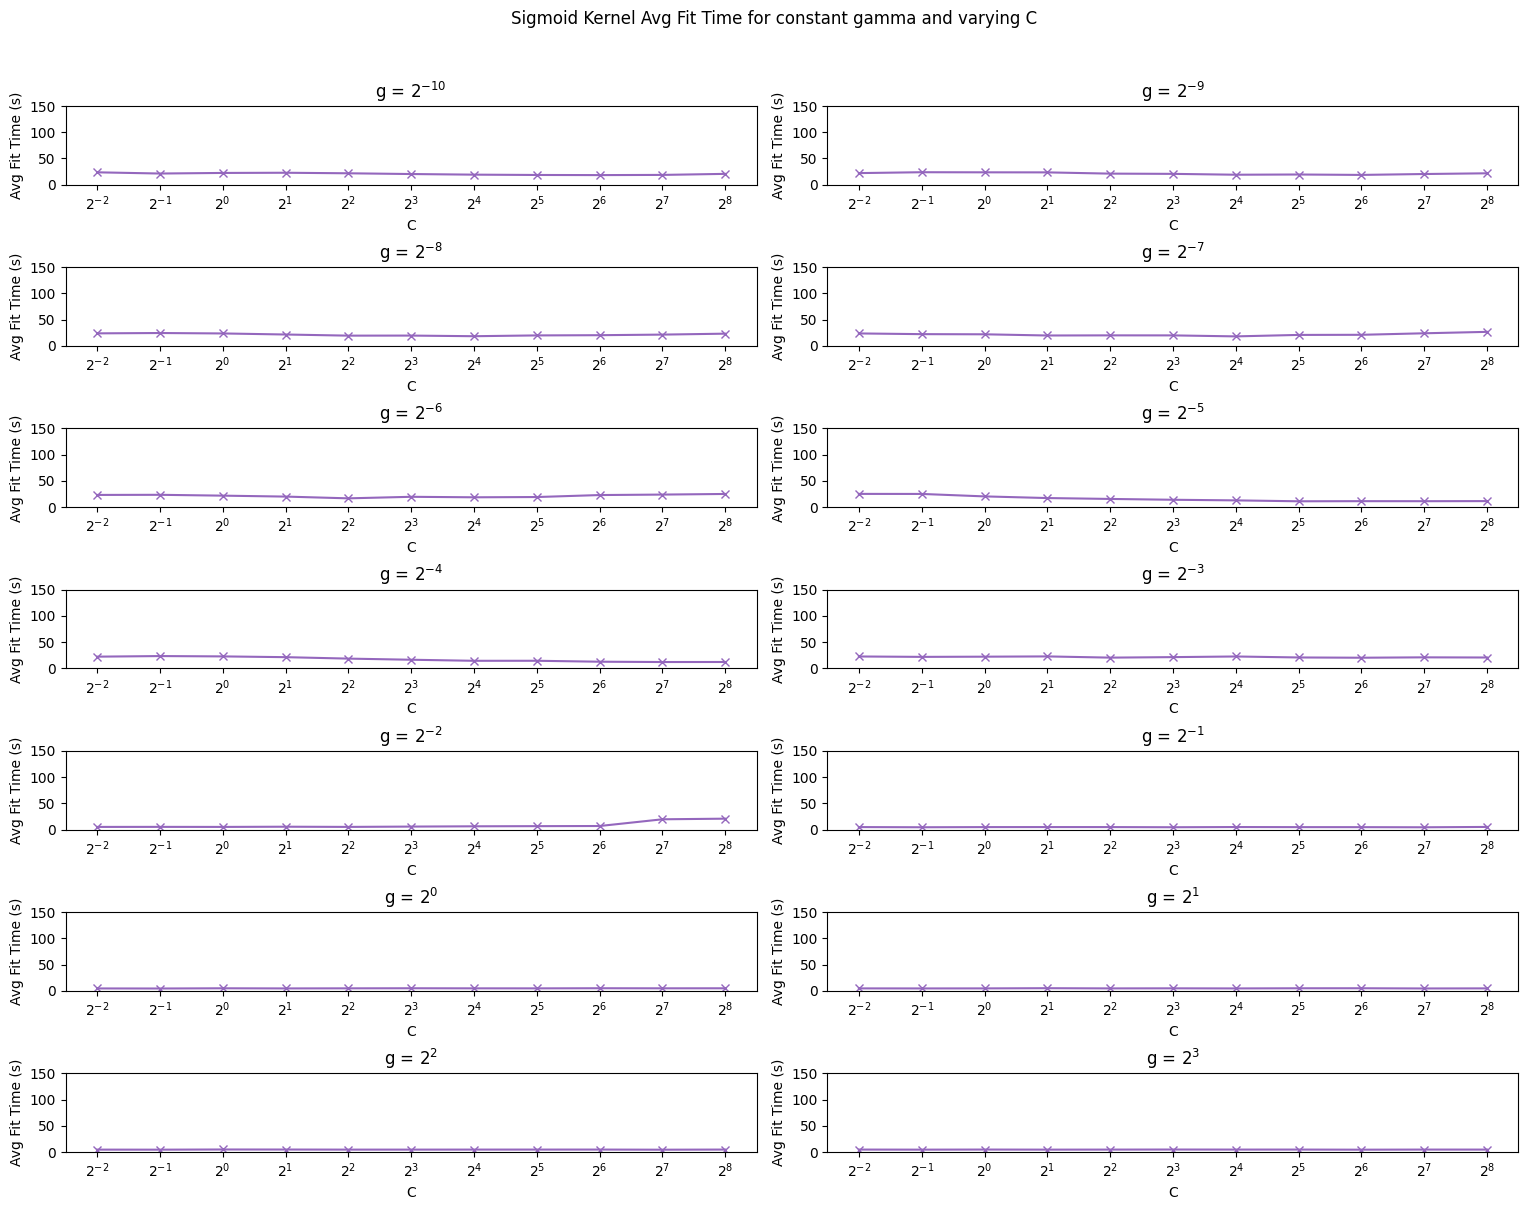

In [44]:
plot_time(df_sigmoid, df_sigmoid.param_gamma, df_sigmoid.param_C, gamma_vals, C_vals, "gamma", "C", g_names, "Sigmoid")

#### Σταθερό C και διάφορες τιμές gamma

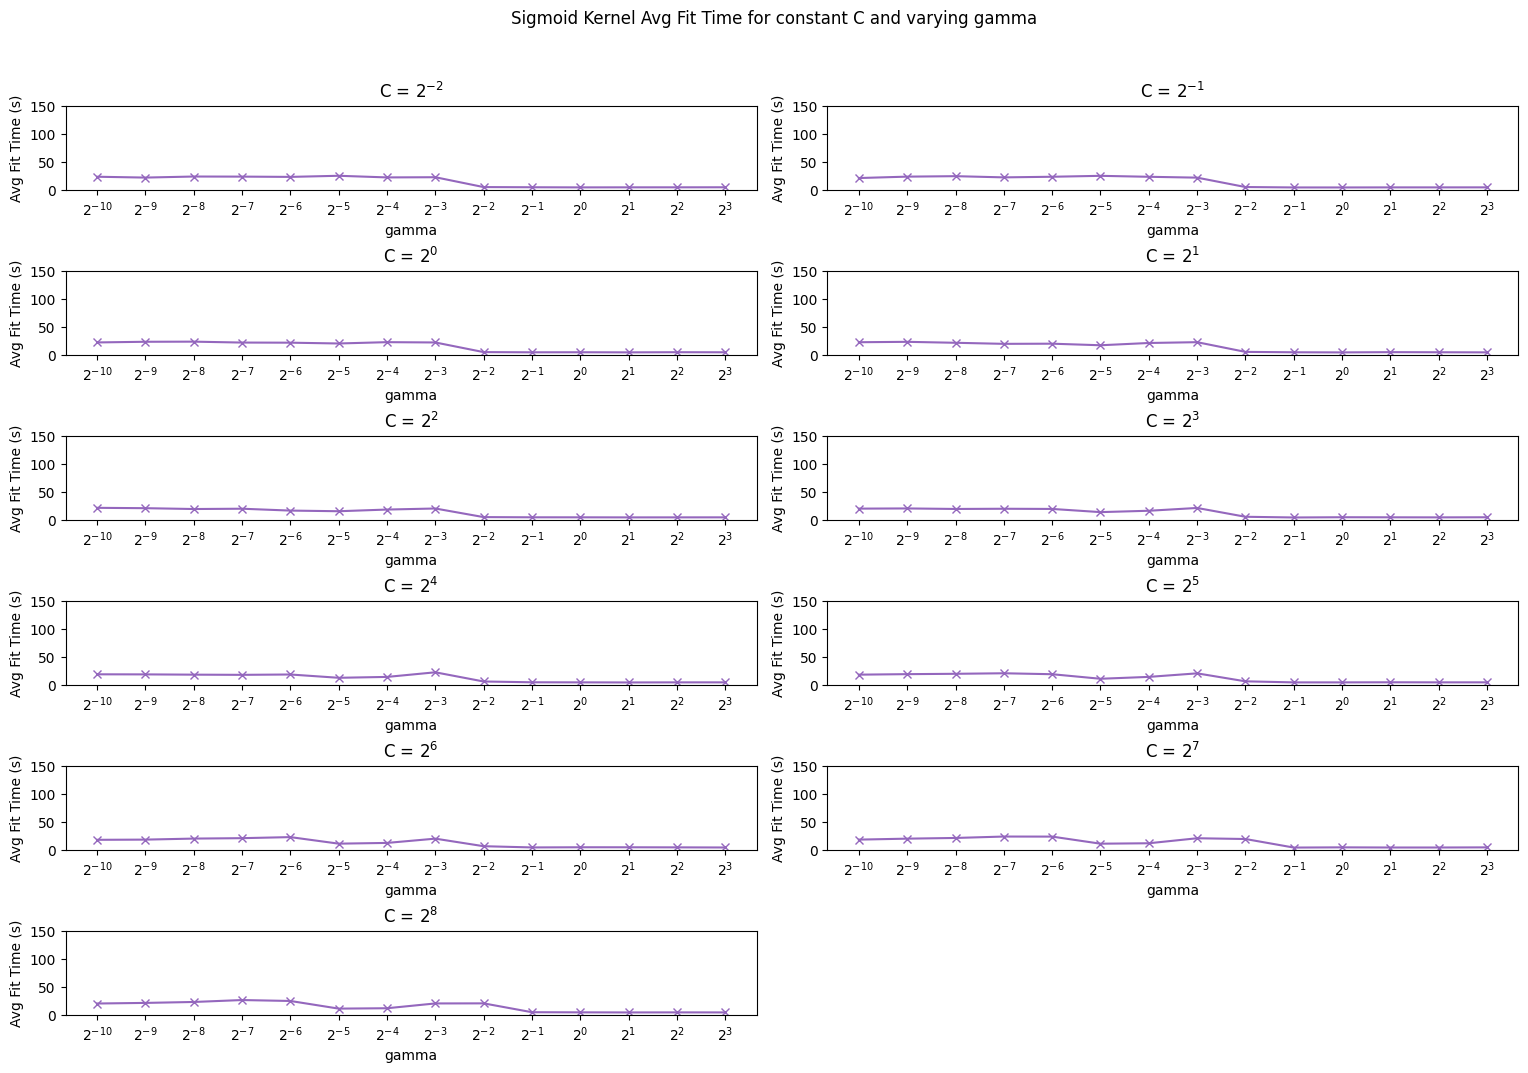

In [45]:
plot_time(df_sigmoid, df_sigmoid.param_C, df_sigmoid.param_gamma, C_vals, gamma_vals, "C", "gamma", C_names, "Sigmoid")

Παρατηρούμε ότι γενικότερα ο χρόνος δεν επηρεάζεται αισθητά από τις τιμές των παραμέτρων, ενώ ειδικότερα για μεγάλα γ, είναι πολύ χαμηλός, γεγονός που προφανώς συνδέεται με την κακή απόδοση των μοντέλων με υψηλό γ (για sigmoid kernel)

### Poly Kernel

#### Σταθερό gamma και διάφορες τιμές C

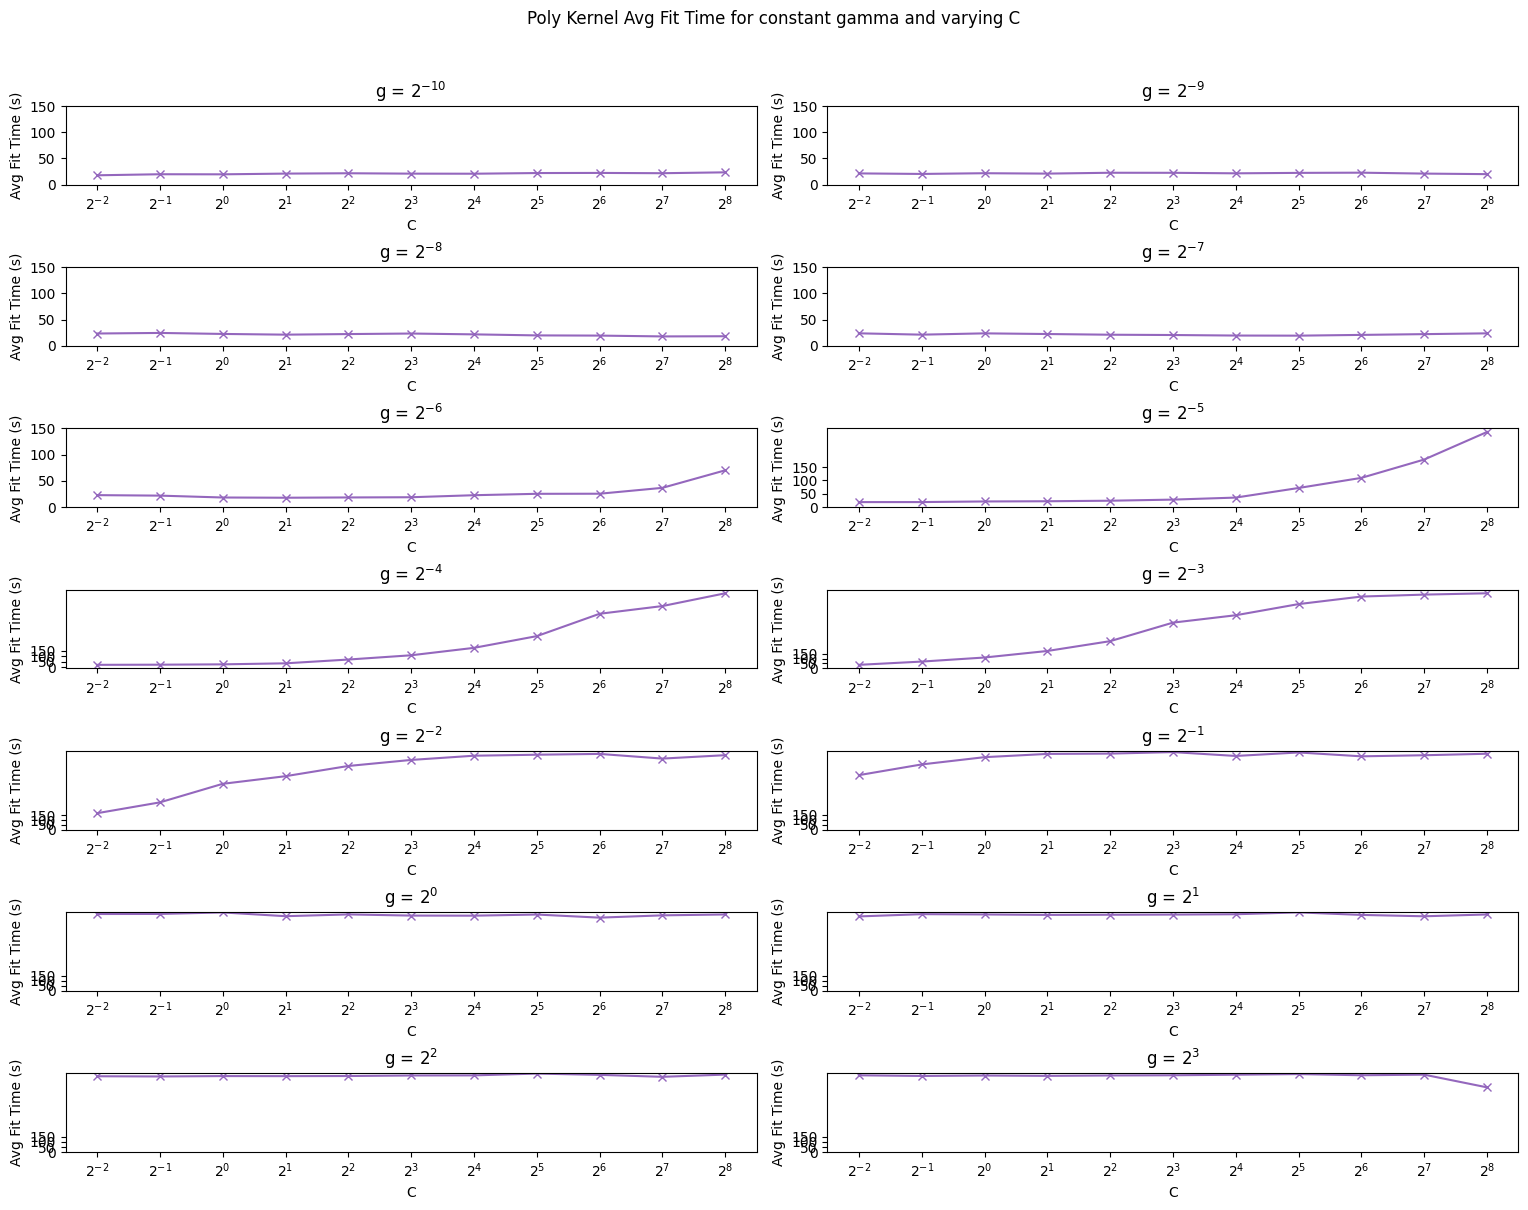

In [51]:
plot_time(df_poly, df_poly.param_gamma, df_poly.param_C, gamma_vals, C_vals, "gamma", "C", g_names, "Poly")

#### Σταθερό C και διάφορες τιμές gamma

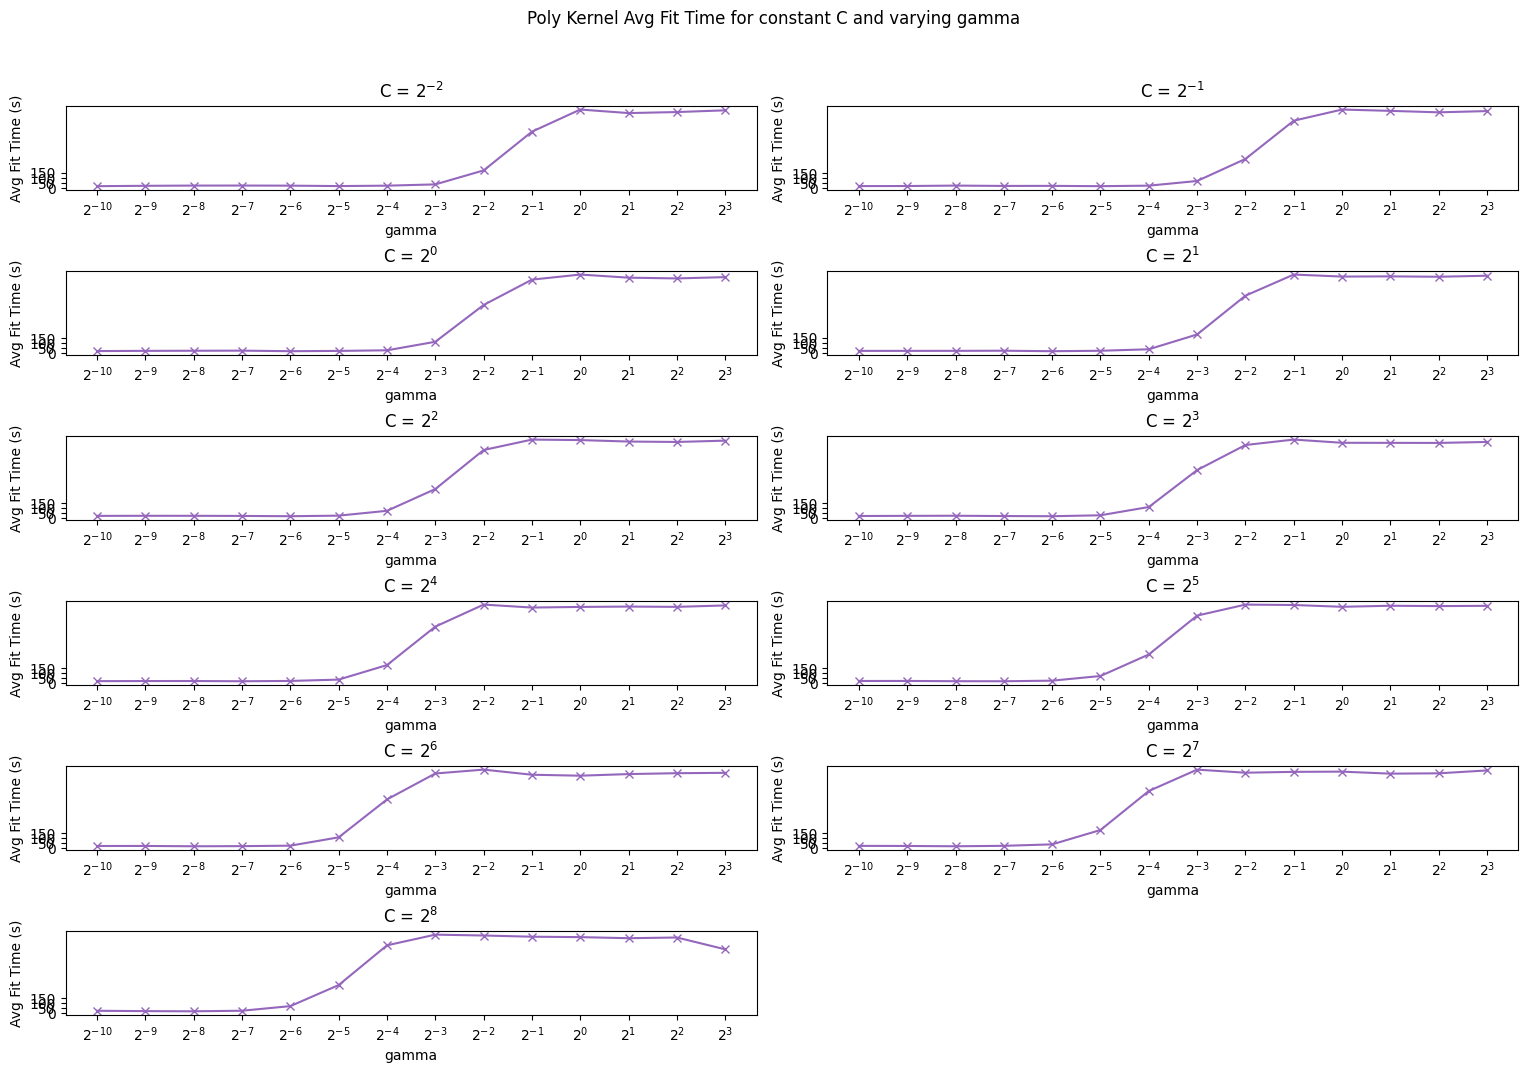

In [50]:
plot_time(df_poly, df_poly.param_C, df_poly.param_gamma, C_vals, gamma_vals, "C", "gamma", C_names, "Poly")

Παρατηρούμε ότι για χαμηλά και υψηλά γ ο χρόνος είναι σταθερός και ανεξάρτητος του C, ενώ για $2^{-5} <= \gamma <= 2^{-3}$  όσο αυξάνει το C αυξάνει και ο χρόνος.

### Linear Kernel

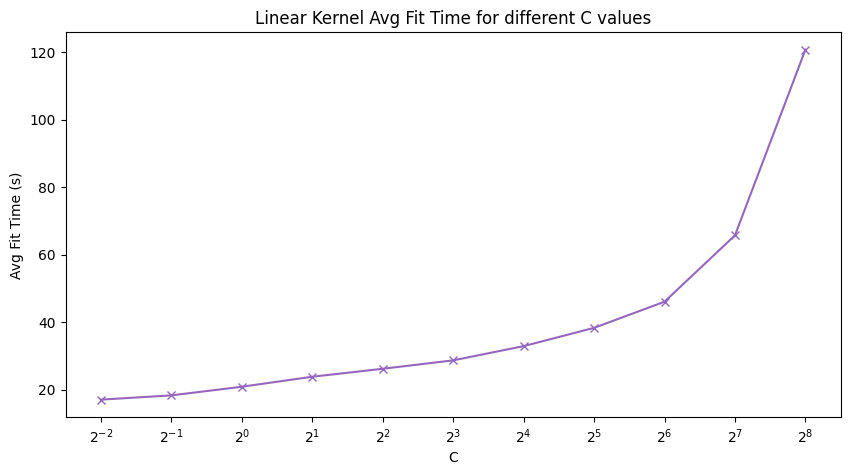

In [53]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

param_C = df_linear.param_C
mean_fit_time = df_linear.mean_fit_time

ax.plot(param_C, mean_fit_time, '-x', color="tab:purple")
ax.set_xscale('log', base=2)
ax.set_xticks(C_vals) 
ax.title.set_text("Linear Kernel Avg Fit Time for different C values")
ax.set(xlabel="C", ylabel='Avg Fit Time (s)')

plt.show()

Εδώ παρατηρούμε μια εμφανή εξάρτηση του χρόνου εκπαίδευσης με την τιμή του C.

### Σύγκριση μέσων χρόνων για διαφορετικά C

In [54]:
avg_times_rbf = []

for c in C_vals:
    focus = df_rbf.param_C == c
    avg_times_rbf.append(np.mean(df_rbf.mean_fit_time[focus]))

avg_times_poly = []

for c in C_vals:
    focus = df_poly.param_C == c
    avg_times_poly.append(np.mean(df_poly.mean_fit_time[focus]))

avg_times_sigmoid = []

for c in C_vals:
    focus = df_sigmoid.param_C == c
    avg_times_sigmoid.append(np.mean(df_sigmoid.mean_fit_time[focus]))

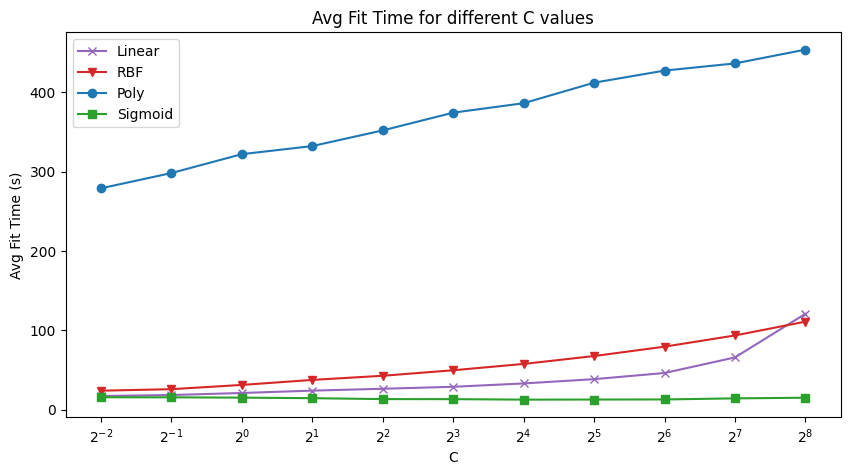

In [55]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

param_C = df_linear.param_C
mean_fit_time = df_linear.mean_fit_time

ax.plot(param_C, mean_fit_time, '-x', color="tab:purple")
ax.plot(param_C, avg_times_rbf, '-v', color="tab:red")
ax.plot(param_C, avg_times_poly, '-o', color="tab:blue")
ax.plot(param_C, avg_times_sigmoid, '-s', color="tab:green")
ax.set_xscale('log', base=2)
ax.set_xticks(C_vals) 
ax.title.set_text("Avg Fit Time for different C values")
ax.set(xlabel="C", ylabel='Avg Fit Time (s)')
ax.legend(["Linear", "RBF", "Poly", "Sigmoid"])

plt.show()

Παραπάνω έχουν παρθεί οι μέσοι όροι (των μέσων όρων του CV) για συγκεκριμένο C (οπότε μο μεταξύ των τιμών της παραμέτρου γ), ώστε να μπορεί να γίνει μια πιο οπτική σύγκριση μεταξύ των χρόνων εκπαίδευσης των μοντέλων με διαφορετικά kernels.

Όπως βλέπουμε τα μοντέλα που χρησιμοποιούν Sigmoid kernel έχουν πάντα χαμηλότερο χρόνο εκπαίδευσης.

Γενικότερα, θα περιμέναμε τα μοντέλα με γραμμικό kernel να έχουν πάντοτε χαμηλότερο χρόνο εκπαίδευσης, αλλά ο χρόνος μπορεί να επηρεάζεται από το γεγονός ότι γίνεται χρήση της Intel® Extension for Scikit-learn βιβλιοθήκης.

# Τελικό Μοντέλο
Παρακάτω εκπαιδεύεται ένα τελικό μοντέλο βάσει των βέλτιστων παραμέτρων που βρέθηκαν από το GridSearchCV

In [56]:
print(f"Best parameters found by GridSearch: {best_params}")

Best parameters found by GridSearch: {'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}


In [57]:
# If GridSearchCV was not executed in this run, train a model with the best parameters found by the previous run
if not perform_gridsearch:
    clf = SVC(C=best_params["C"], gamma=best_params["gamma"], kernel=best_params["kernel"])
    clf.fit(x_train, y_train)

In [73]:
train_score = clf.score(x_train,y_train)
test_score = clf.score(x_test,y_test)

In [74]:
print(f"Final Model using {best_params}\n")
print(f"Train Set Accuracy: {train_score}\n")
print(f"Test Set Accuracy: {test_score}\n")

Final Model using {'C': 2, 'gamma': 0.5, 'kernel': 'rbf'}

Train Set Accuracy: 0.97304

Test Set Accuracy: 0.9039



## Παραδείγματα προβλέψεων

In [62]:
start_pred = time()
y_pred = clf.predict(x_test)
end_pred = time()

svm_model_pred_time = end_pred - start_pred
print(f"Prediction Time: {svm_model_pred_time} s\n")
wrong_predictions = np.where(np.not_equal(y_pred, y_test))[0]
correct_predictions = np.where(np.equal(y_pred,y_test))[0]
random.shuffle(wrong_predictions)
random.shuffle(correct_predictions)

Prediction Time: 0.8613030910491943 s



### Παραδείγματα λανθασμένων προβλέψεων
Παρακάτω παρουσιάζονται ενδεικτικά μερικές εικόνες όπου το μοντέλο έκανε λανθασμένη πρόβλεψη.

Όπως φαίνεται, σε μερικές από αυτές ακόμη και άνθρωπος θα μπορούσε να είχε κάνει λάθος κατηγοριοποίηση.

#### Συμπιεσμένη εικόνα

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


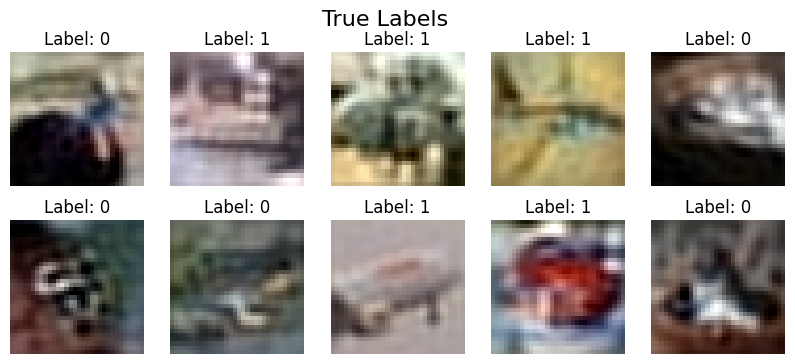

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


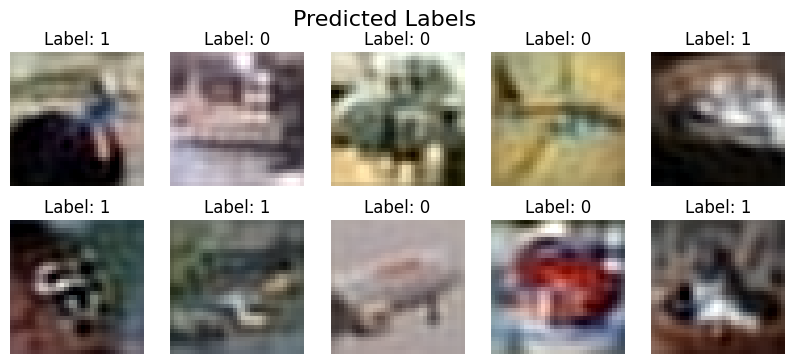

In [63]:
show_predictions(wrong_predictions, y_test, y_pred, X_test_filt)

#### Αρχική εικόνα

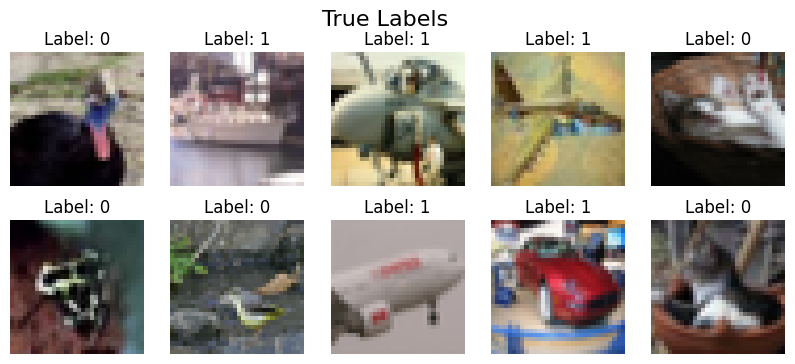

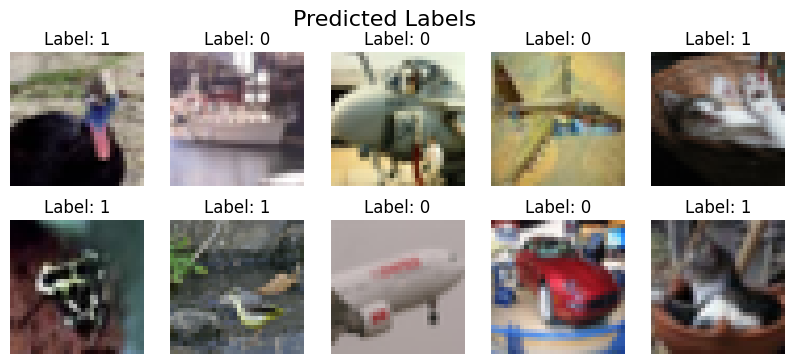

In [64]:
show_predictions(wrong_predictions, y_test, y_pred, X_test)

### Παραδείγματα σωστών προβλέψεων

#### Συμπιεσμένη εικόνα

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


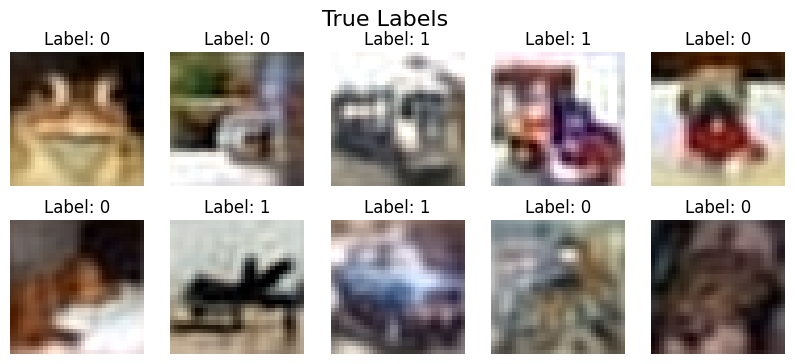

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


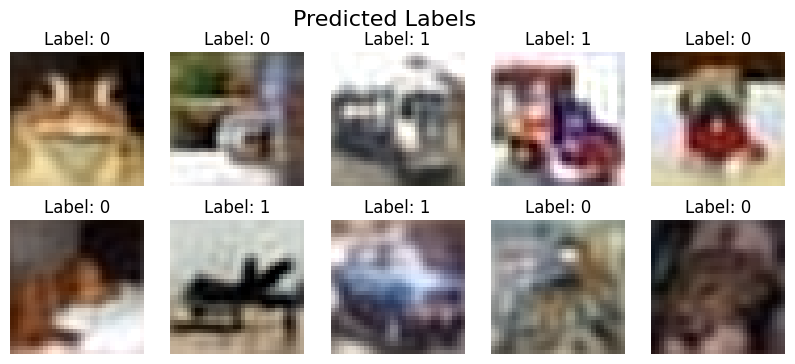

In [65]:
show_predictions(correct_predictions, y_test, y_pred, X_test_filt)

#### Αρχική εικόνα

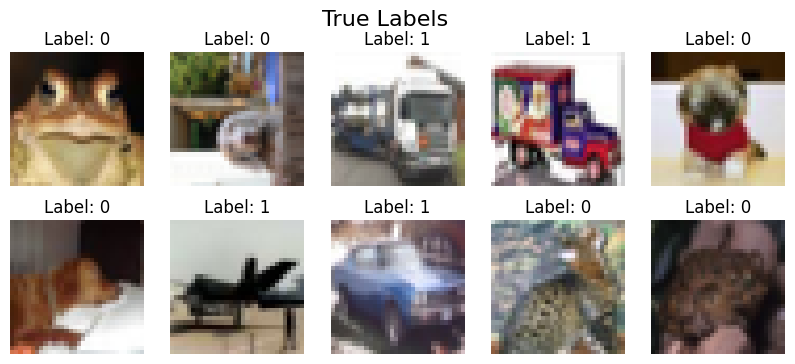

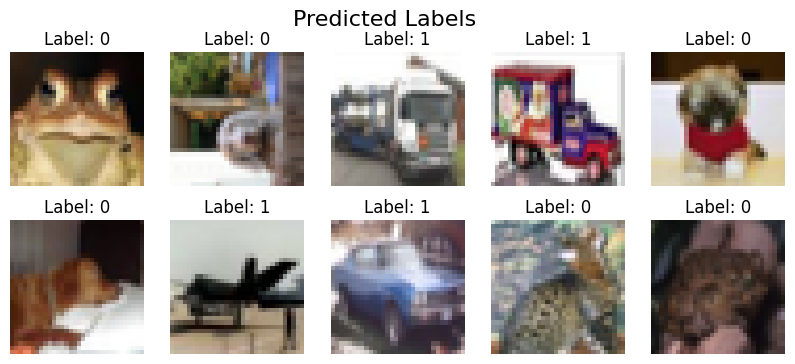

In [66]:
show_predictions(correct_predictions, y_test, y_pred, X_test)

# kNN and Nearest Centroid


In [67]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid


In [68]:
def knn_model(X_train, y_train, X_test, y_test, k):

    
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    knn = KNeighborsClassifier(n_neighbors=k)

    
    # Train the model using the training sets
    start = time()
    knn.fit(X_train, y_train)
    end = time()
    
    start_pred = time()
    y_pred = knn.predict(X_test)
    end_pred = time()
    
    score = knn.score(X_test, y_test)
    # Show how many neighbors are used and print the metrics
    print(f"{k}-Nearest Neighbors\nAccuracy: {score}\nTraining Time: {end-start} s\nPrediction Time: {end_pred-start_pred} s\n")

In [69]:
for k in [1, 3]:
    knn_model(x_train, y_train, x_test, y_test, k)

1-Nearest Neighbors
Accuracy: 0.7255
Training Time: 0.057030439376831055 s
Prediction Time: 1.6594552993774414 s

3-Nearest Neighbors
Accuracy: 0.737
Training Time: 0.041019439697265625 s
Prediction Time: 1.736027479171753 s



In [70]:
nc = NearestCentroid(shrink_threshold=0.9)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

start = time()
nc.fit(x_train, y_train)
end = time()

fit_time_nc = end-start

start = time()
score = nc.score(x_test, y_test)
end = time()

pred_time_nc = end-start
print(f"Nearest Centroid\nAccuracy: {score}\nTraining Time: {fit_time_nc} s\nPrediction Time: {pred_time_nc} s\n")

Nearest Centroid
Accuracy: 0.7595
Training Time: 0.1673750877380371 s
Prediction Time: 0.39479589462280273 s



c:\Users\nicka\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nicka\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [71]:
print(f"Prediction Time (SVM Final Model): {svm_model_pred_time}\n")

Prediction Time (SVM Final Model): 0.8613030910491943



Όπως φαίνεται τα μοντέλα k-NN έχουν χαμηλότερη απόδοση από το τελικό μοντέλο που κάνει χρήση SVM.
Όμως έχουν αρκετά υψηλή απόδοση, και μάλιστα υψηλότερη από πολλά από τα μοντέλα που δοκιμάστηκαν.

Επιπλέον, το k-NN μοντέλο είναι πιο γρήγορο στην "εκπαίδευσή" (αφού δεν κάνει εκπαίδευση, και απλώς αποθηκεύει τα δεδομένα) του από το SVM που προσπαθεί να βελτιστοποιήσει το διαχωρισμό των δεδομένων.
Ο χρόνος πρόβλεψης, όμως, είναι πολύ μεγαλύτερος συγκριτικά με το SVM μοντέλο.

Όσο αφορά το μοντέλο Nearest Centroid, βλέπουμε ότι η απόδοση του είναι χαμηλή συγκριτικά με τα μοντέλα των k-NN και του τελικού SVM μοντέλου.
Παρόλα αυτά έχει 2 τάξεις μεγέθους πιο γρήγορο χρόνο πρόβλεψης από το SVM μοντέλο! Αυτό είναι και λογικό, καθώς κάνει απλώς σύγκριση του νέου δεδομένου που θέλει να κατηγοριοποιήση μεταξύ των κέντρων των κλάσεων (σε αυτήν την περίπτωση 2).

Συνολικά, βλέπουμε ότι το SVM μοντέλο υπερτερεί σε ακρίβεια, το kNN σε χρόνο "εκπαίδευσης", και το NC σε χρόνο πρόβλεψης. Τελικώς, όμως, το SVM μοντέλο είναι αυτό που προτιμάται, καθώς είναι πιο ευέλικτο, παρέχει υψηλότερη ακρίβεια, και αφόυ γίνει η εκπαίδευσή του, 
κατηγοριοποιεί γρήγορα νέα δεδομένα.
